#  Project, Part01: predict California housing values, circa 1990

There are some interesting data analysis issues associated with the California housing dataset that Aurelien Geron works with in his book, *Hands-On Machine Learning with Scikit-Learn & Tensorflow*.  See https://github.com/ageron/handson-ml/tree/master/datasets/housing.  Geron writes:

"This dataset appeared in a 1997 paper titled *Sparse Spatial Autoregressions* by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people)."

The original data for this project can be found at https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html, a web page maintained by Luís Torgo (University of Porto).  Geron notes that "the dataset may also be downloaded from StatLib mirrors."  

Geron slightly modifies the dataset.  He randomly removes 207 values for the variable, total_bedrooms, in order to discuss in his book how to handle missing data.  Also, he adds the categorical variable, ocean_proximity, in order to show how to handle categorical data in a machine learning pipeline.  When modeling the data with a linear model, only 2 of the 5 levels for ocean_proximity significantly help to predict median house values for the 20K-plus districts in the dataset.  A special transformation of the longitude values in the dataset greatly diminishes the need for this variable.  For this project I make use of Geron's modified dataset.


                                        * * * * * 


The purpose of *this* project is to carefully examine the variables in this dataset and to see what can be done with them so that we can better predict the median house values for the California census districts.  The steps taken here to reach that end are steps common to many data analytic projects.  For example, I bring in additional data---in this case an urbanacity metric---so that we can get more accurate predictions of the response variable.  I show why there is a need to transform the longitude variable and that, with the right transformation, we can dramatically increase its predictive power.  I remove the extreme values that would interfere with modeling the vast majority of the data.  I identify the most valuable predictors for the models we are working with and, for the OLS model of Part01, identify the model terms which are highly collinear.  

Some of the steps taken here are specific to working with geospatial data.  Two of the steps involve imputing values for censored data.  housing_median_age is capped at 52 years, and median_house_value (the response variable) is capped at \$500K.  Altogether, around 10\% of the 20,640 records are censored.  The California housing dataset is of particular interest to me both because it involves geospatial data and because the censored data presents a challenge for getting accurate predictions of the response variable.  In appendices A, B, and C I take a close look at how we can improve upon a Gibbs sampler approach to imputing values for the censored data.  If this project offers anything new or original, it is largely found with this improved method for imputating values.  Overall, I am also trying to show how we can leverage statistics and statistical analysis to improve upon machine learning approaches to modeling data.  For example, a major benefit of the work done in this Part01 is that it allows the ML algorithms surveyed in Part02 to run quite a bit faster.  The preliminary variable analysis and modeling also provide us with insights into where resources should be focused for future data collection if our primary purpose is having the data necessary for getting good predictions of median house values. 



Part01 of this project leads toward finding a "best" *linear* model.  Model performance is measured in terms of the root mean squared error (rmse).  Part02 then looks at a range of ML models. 


                                        * * * * * 



# Section 1: Preliminary housekeeping

In what follows, I address issues which I already know from previous work exist with the data.  In this section only main decision points with respect to data cleaning are shown.  I also show a couple of very important enhancements to the dataset.



In [ ]:
# Some packages we will need.

require(corrgram)
require(GGally)  # for scatterplot "tool"
require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm)     # needed for Gibbs sampling used in imputation


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [51]:
# Bring in the original dataset.  There are 9 predictors and
# one response variable, median_house_value.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing.csv", 
                header= TRUE, colClasses= c(rep("numeric", 9), "character"))
dim(dat)
# 20,640    10

colnames(dat)


[1] 20640    10

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"

## Modify categorical variable, ocean_proximity

The ISLAND level of ocean_proximity has a very small number of records, too small to be of much help lowering the overall rmse of our model.  It might also interfere with the cross-validation scores used to identify the best parameters for our machine learning models.  For these reasons I combine the ISLAND records with the OCEAN group.

In [52]:
# Get counts for levels of ocean_proximity.

table(as.factor(dat$ocean_proximity))



 <1H OCEAN     INLAND     ISLAND   NEAR BAY NEAR OCEAN 
      9136       6551          5       2290       2658 

In [53]:
str(dat$ocean_proximity)


 chr [1:20640] "NEAR BAY" "NEAR BAY" "NEAR BAY" "NEAR BAY" "NEAR BAY" ...


In [54]:
# Change ocean_proximity to a factor.

dat$ocean_proximity <- as.factor(dat$ocean_proximity)
levels(dat$ocean_proximity) <- c("OCEAN", levels(dat$ocean_proximity)[2:5])


In [32]:
# Find out the degree to which the median house values differ
# in each of the ocean_proximity levels.

tmpdat <- dat
tmpdat$dummyvar <- 1
cat_counts <- aggregate(dummyvar ~ ocean_proximity, sum, data=tmpdat)
rm(tmpdat)
cat_medians <- aggregate(median_house_value ~ ocean_proximity, median, data=dat)
cat_means <- aggregate(median_house_value ~ ocean_proximity, mean, data=dat)
cat_stddevs <- aggregate(median_house_value ~ ocean_proximity, sd, data=dat)
df <- cbind(cat_counts, cat_medians$median_house_value, 
            cat_means$median_house_value, cat_stddevs$median_house_value)
colnames(df) <- c("ocean_proximity", "count", "group_median", "group_avg", "sd")
df$avg.se <- round(df$sd/sqrt(df$count))
df


ocean_proximity,count,group_median,group_avg,sd,avg.se
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OCEAN,9136,214850,240084,106124,1110
INLAND,6551,108500,124805,70008,865
ISLAND,5,414700,380440,80560,36027
NEAR BAY,2290,233800,259212,122819,2567
NEAR OCEAN,2658,229450,249434,122477,2376


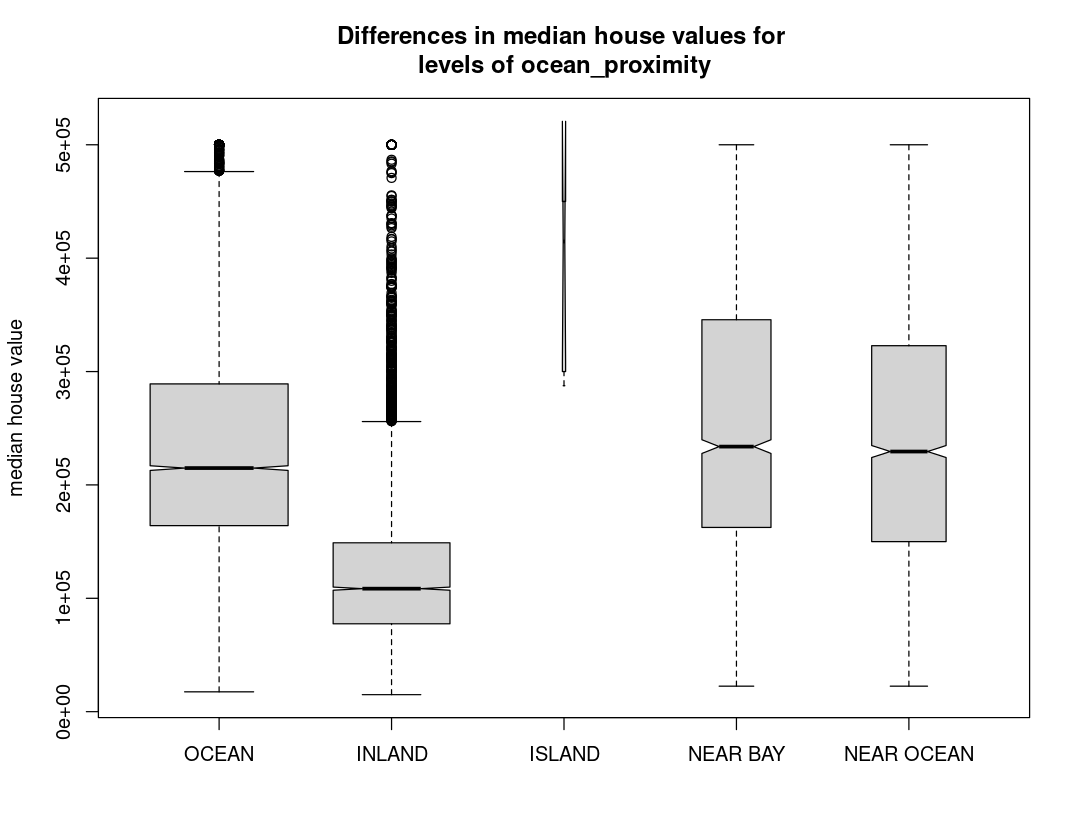

In [33]:
# A boxplot is also useful here.

options(repr.plot.width= 9, repr.plot.height= 7)

suppressWarnings(boxplot(median_house_value ~ ocean_proximity, data=dat, 
        main="Differences in median house values for 
levels of ocean_proximity", xlab="",
        ylab="median house value", notch=TRUE, varwidth=TRUE))


In [ ]:
### COMMENTS: 

# The most important difference lies between OCEAN and INLAND.
# About 75% of the records in our dataset belong to these 2
# levels.  Notice that values tend to increase as one moves
# closer to the ocean.

# The ISLAND category is quite different from the other groups
# in terms of average and median median house values, but 
# keeping this level in the analysis will do very little to improve
# our models' rmse scores.  The problem is the extremely low
# number of ISLAND districts.  When constructing models using
# cross-validation, we would like to have records from each of the
# groups in both the training and validation sets.  With only 5
# records in the group, there is no guarantee this will happen.

# For this reason, I combine the ISLAND records with the OCEAN
# group.


In [55]:
# Combine ISLAND and OCEAN categories.

dat[which(dat$ocean_proximity == "ISLAND"), c("ocean_proximity")] <- "OCEAN"

# Drop the unused level.
dat$ocean_proximity <- factor(dat$ocean_proximity)
table(dat$ocean_proximity)



     OCEAN     INLAND   NEAR BAY NEAR OCEAN 
      9141       6551       2290       2658 

## Fill in the missing values that Geron created

In [56]:
# The total_bedrooms variable has missing values.

summary(dat[, 1:9])


   longitude       latitude    housing_median_age  total_rooms   
 Min.   :-124   Min.   :32.5   Min.   : 1.0       Min.   :    2  
 1st Qu.:-122   1st Qu.:33.9   1st Qu.:18.0       1st Qu.: 1448  
 Median :-118   Median :34.3   Median :29.0       Median : 2127  
 Mean   :-120   Mean   :35.6   Mean   :28.6       Mean   : 2636  
 3rd Qu.:-118   3rd Qu.:37.7   3rd Qu.:37.0       3rd Qu.: 3148  
 Max.   :-114   Max.   :42.0   Max.   :52.0       Max.   :39320  
                                                                 
 total_bedrooms   population      households   median_income  
 Min.   :   1   Min.   :    3   Min.   :   1   Min.   : 0.50  
 1st Qu.: 296   1st Qu.:  787   1st Qu.: 280   1st Qu.: 2.56  
 Median : 435   Median : 1166   Median : 409   Median : 3.53  
 Mean   : 538   Mean   : 1425   Mean   : 500   Mean   : 3.87  
 3rd Qu.: 647   3rd Qu.: 1725   3rd Qu.: 605   3rd Qu.: 4.74  
 Max.   :6445   Max.   :35682   Max.   :6082   Max.   :15.00  
 NA's   :207                   

In [57]:
# Compute correlation betw. log(total_bedrooms) and
# log(median_house_value).  

tmpdat <- dat[, c("median_house_value", "total_bedrooms")]
tmpdat <- na.omit(tmpdat)
tmpdat$total_bedrooms <- log(tmpdat$total_bedrooms)
tmpdat$median_house_value <- log(tmpdat$median_house_value)
round(cor(tmpdat), 3)


,median_house_value,total_bedrooms
median_house_value,1.000,0.087
total_bedrooms,0.087,1.000


In [60]:
rows_to_exclude <- rownames(dat[which(!(rownames(dat) %in% rownames(tmpdat))),])
length(rows_to_exclude)


[1] 207

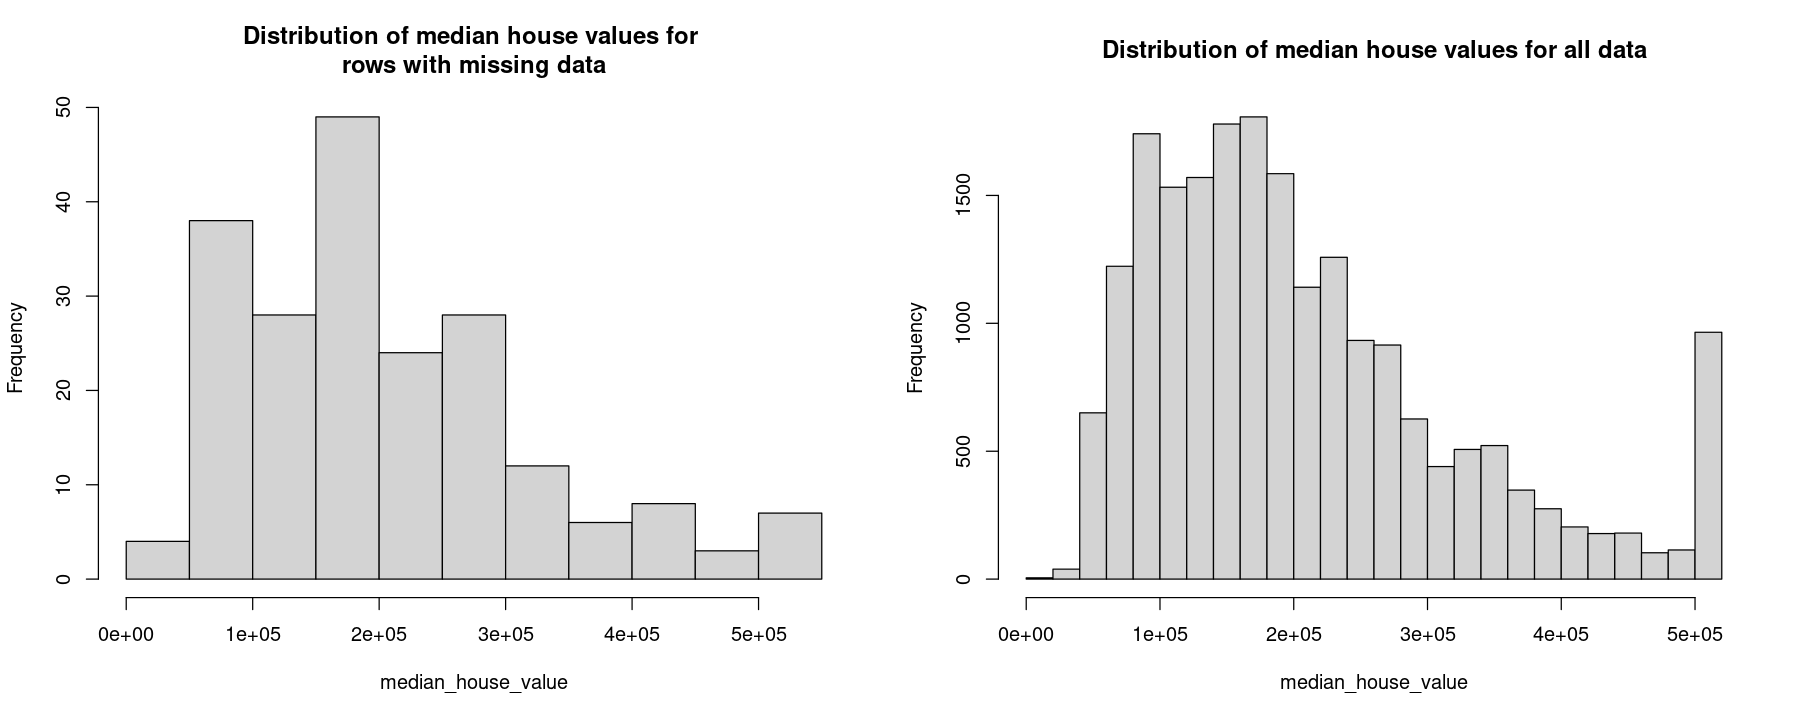

In [61]:
# total_bedrooms has 207 missing values.  Given the
# low linear correlation it has with median_house_value,
# it will not be an especially strong predictor in our
# model.  207 is also only 1% of the 20.6K records that
# we have to work with.  It follows from these two facts
# that we can assign the median value for total_bedrooms 
# to each of the records with a missing value without 
# making a mess of things.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

hist(dat[rows_to_exclude,]$median_house_value, 
     main="Distribution of median house values for 
rows with missing data", breaks=10, xlab="median_house_value")

hist(dat$median_house_value, 
     main="Distribution of median house values for all data", 
     breaks=30, xlab="median_house_value")


In [ ]:
### COMMENT:

# The similarily of the above 2 histograms suggests that
# the rows with missing data are missing at random.


In [62]:
dat[rows_to_exclude, c("total_bedrooms")] <- round(median(dat$total_bedrooms, na.rm=TRUE))
summary(dat$total_bedrooms)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     297     435     537     643    6445 

In [63]:
# Copy dat.

dat.copy <- dat


## Add some variables that might help predict median house values

In [64]:
# As Geron points out in his book, it is worth investigating the 
# value certain combinations of the predictors might have for
# predicting the response variable.  Following Geron, then, let's
# add the variables rooms per household, population per
# household, and bedrooms per room.

dat$rooms_per_hh <- dat$total_rooms/dat$households
dat$bdrms_per_room <- dat$total_bedrooms/dat$total_rooms
dat$pop_per_hh <- dat$population/dat$households

summary(dat[, c("rooms_per_hh","bdrms_per_room","pop_per_hh")])


  rooms_per_hh     bdrms_per_room     pop_per_hh     
 Min.   :  0.846   Min.   :0.0372   Min.   :   0.69  
 1st Qu.:  4.441   1st Qu.:0.1752   1st Qu.:   2.43  
 Median :  5.229   Median :0.2032   Median :   2.82  
 Mean   :  5.429   Mean   :0.2138   Mean   :   3.07  
 3rd Qu.:  6.052   3rd Qu.:0.2401   3rd Qu.:   3.28  
 Max.   :141.909   Max.   :2.8247   Max.   :1243.33  

## Remove records with extreme values

A virtue of linear models is their simplicity.  This is achieved through parameterization of the relationships between the response variable and its predictors.  If done properly, little information is lost through this simplification process.  In fact, if done properly, a linear model can shed light on some of the most important relationships between the response variable and its predictors.  The best models are those which offer the clearest picture of these relationships.  Extreme values often detract from such clarity.

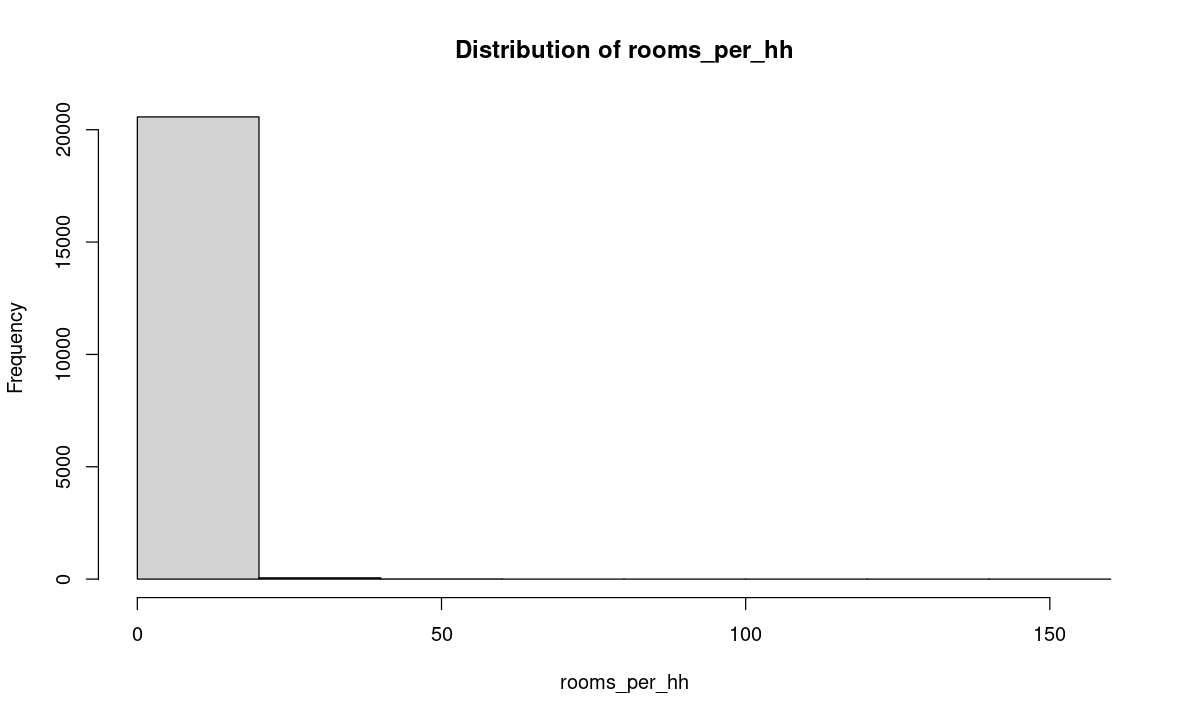

In [66]:
# We see in the above summary output that we have a district 
# in which rooms_per_hh is about 142.  And we have a district
# in which pop_per_hh is over 1,243.  Both these values might
# belong to the same district, perhaps one on an island which
# has many hotels on it.  We shouldn't expect our models to be
# able to handle this extreme data because we simply do not 
# have enough extreme data to work with to make good predictions.
# (If we did have enough such data, the data is arguably no 
# longer extreme.)

options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$rooms_per_hh, breaks=10, main="Distribution of rooms_per_hh",
     xlab="rooms_per_hh")


In [67]:
# Remove extreme values for rooms_per_hh.

dim(dat)
# 20,640
dat <- dat[which(dat$rooms_per_hh <= 40),]
dim(dat)
# 20,629

# 11 records removed.


[1] 20640    13

[1] 20629    13

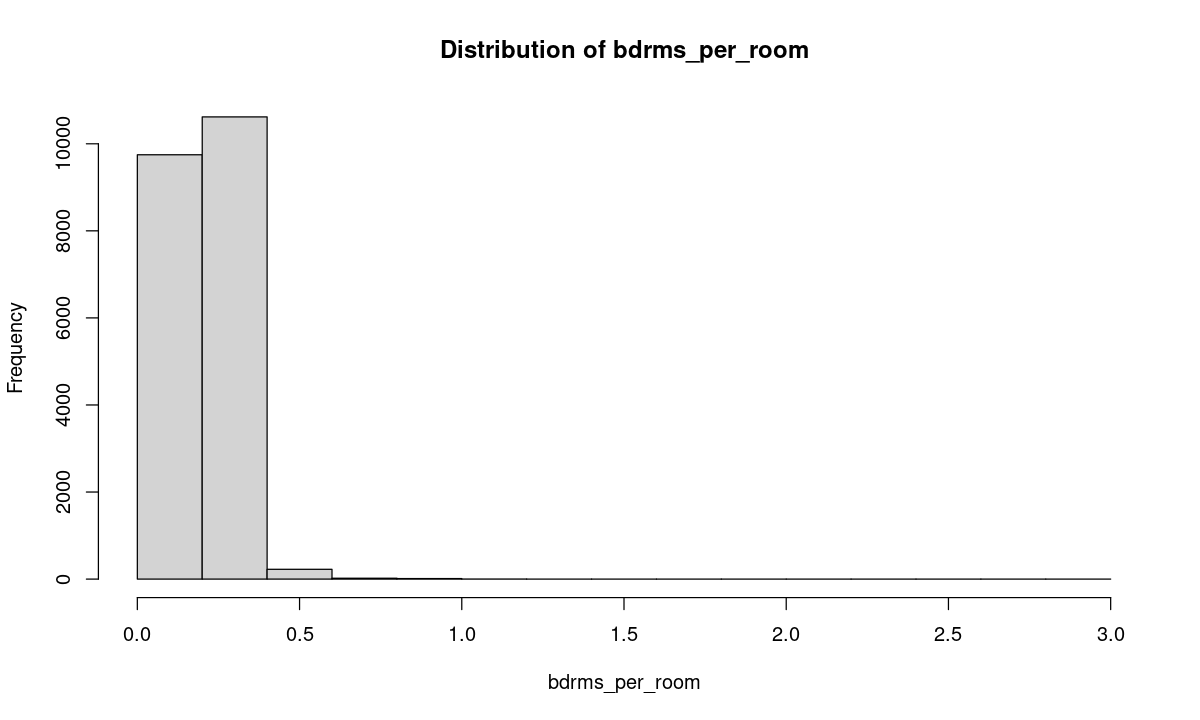

In [68]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$bdrms_per_room, breaks=10, main="Distribution of bdrms_per_room",
     xlab="bdrms_per_room")


In [69]:
# Remove extreme values for bdrms_per_room.

dim(dat)
# 20,629
dat <- dat[which(dat$bdrms_per_room <= 0.95),]
dim(dat)
# 20,621

# 8 records removed.


[1] 20629    13

[1] 20621    13

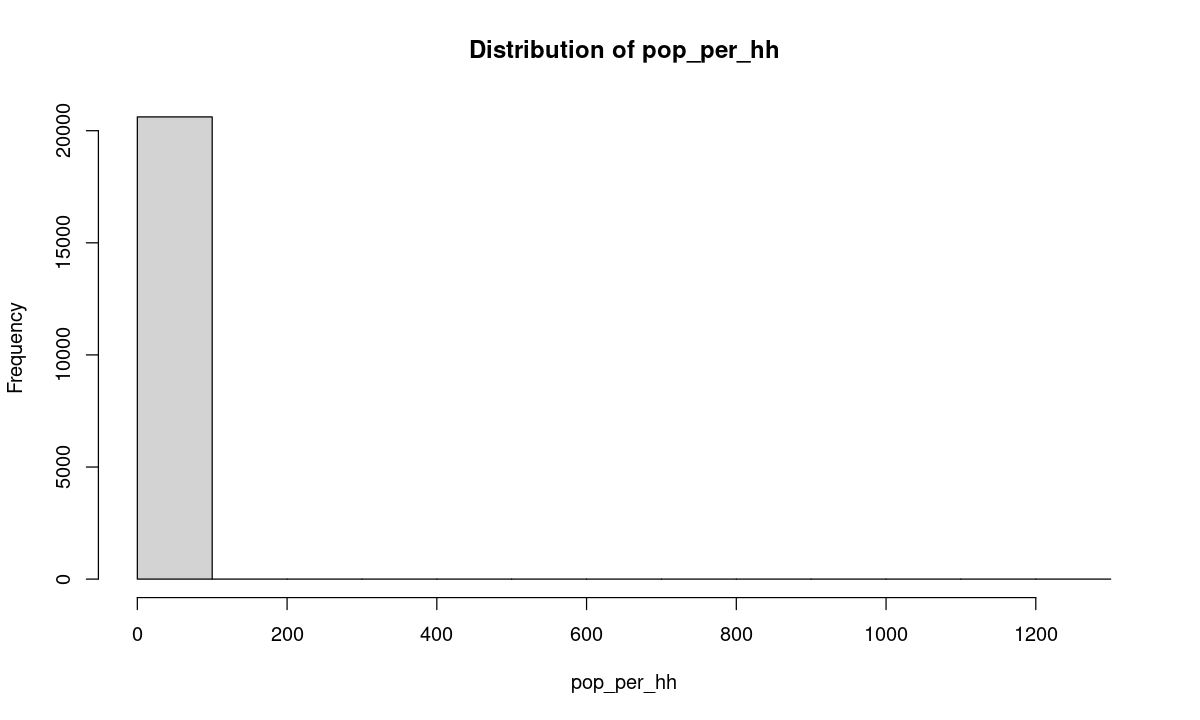

In [70]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$pop_per_hh, breaks=10, main="Distribution of pop_per_hh",
     xlab="pop_per_hh")


In [71]:
# Remove extreme values for pop_per_hh.

dim(dat)
# 20,621
dat <- dat[which(dat$pop_per_hh <= 15),]
dim(dat)
# 20,603

# 18 records removed.


[1] 20621    13

[1] 20603    13

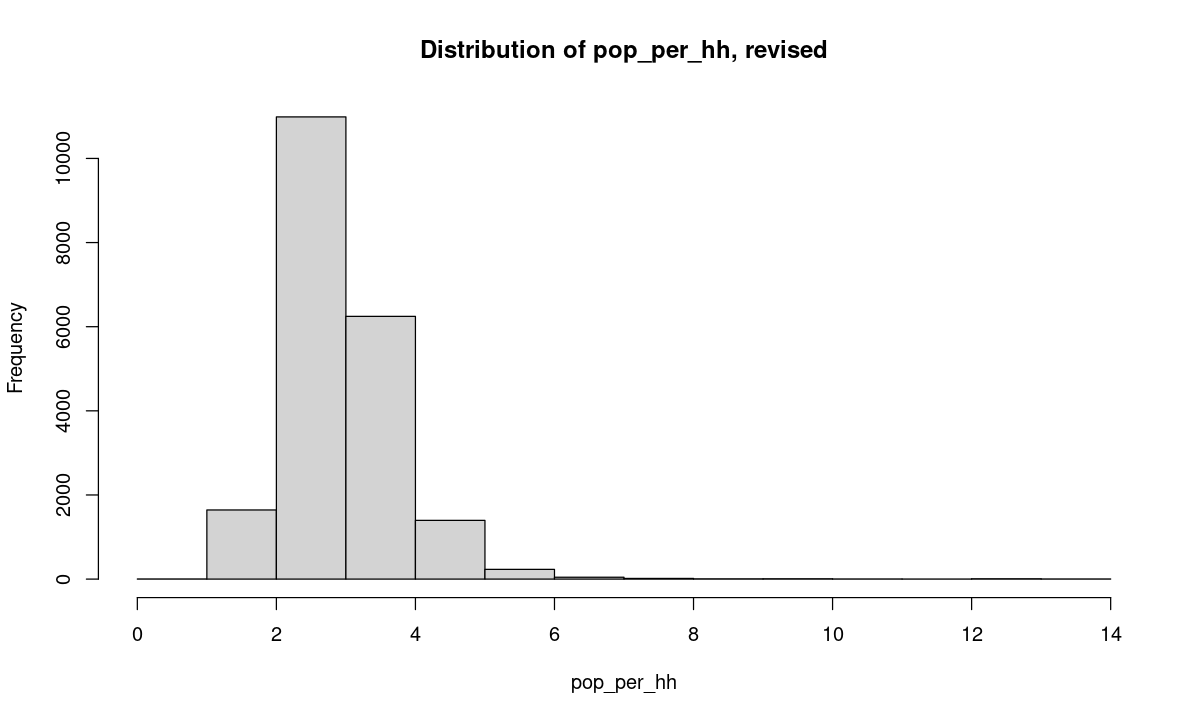

In [72]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$pop_per_hh, breaks=10, main="Distribution of pop_per_hh, revised",
     xlab="pop_per_hh")


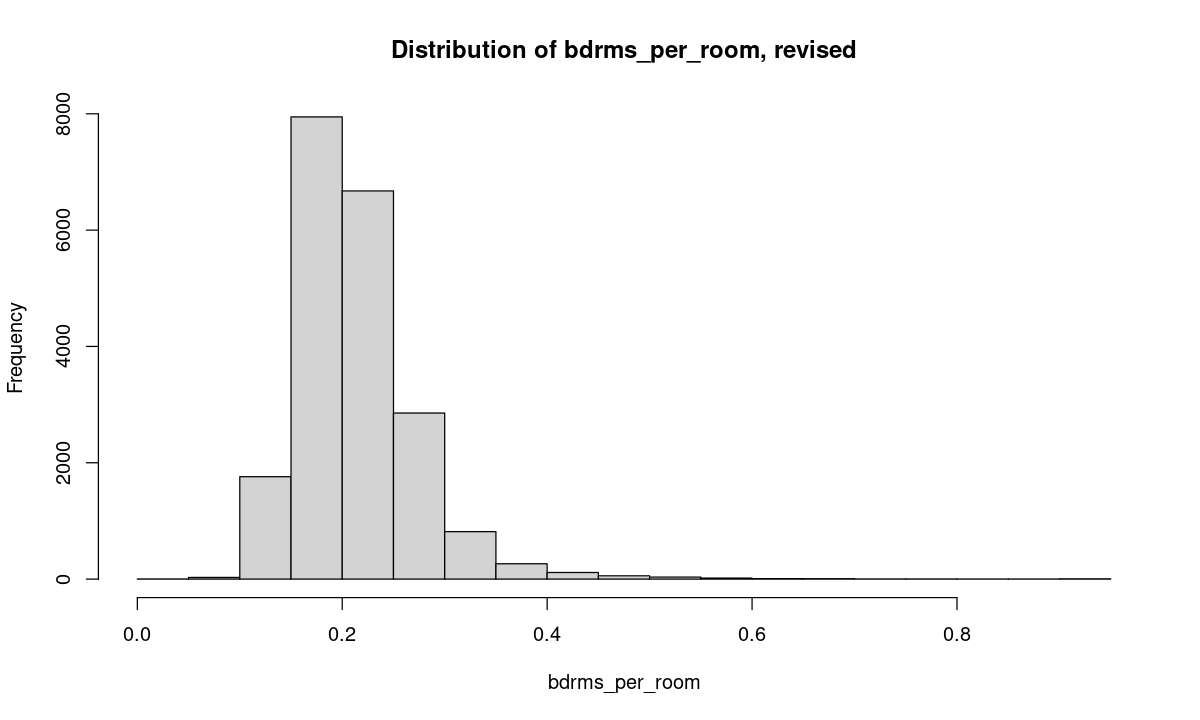

In [76]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$bdrms_per_room, breaks=20, main="Distribution of bdrms_per_room, revised",
     xlab="bdrms_per_room")


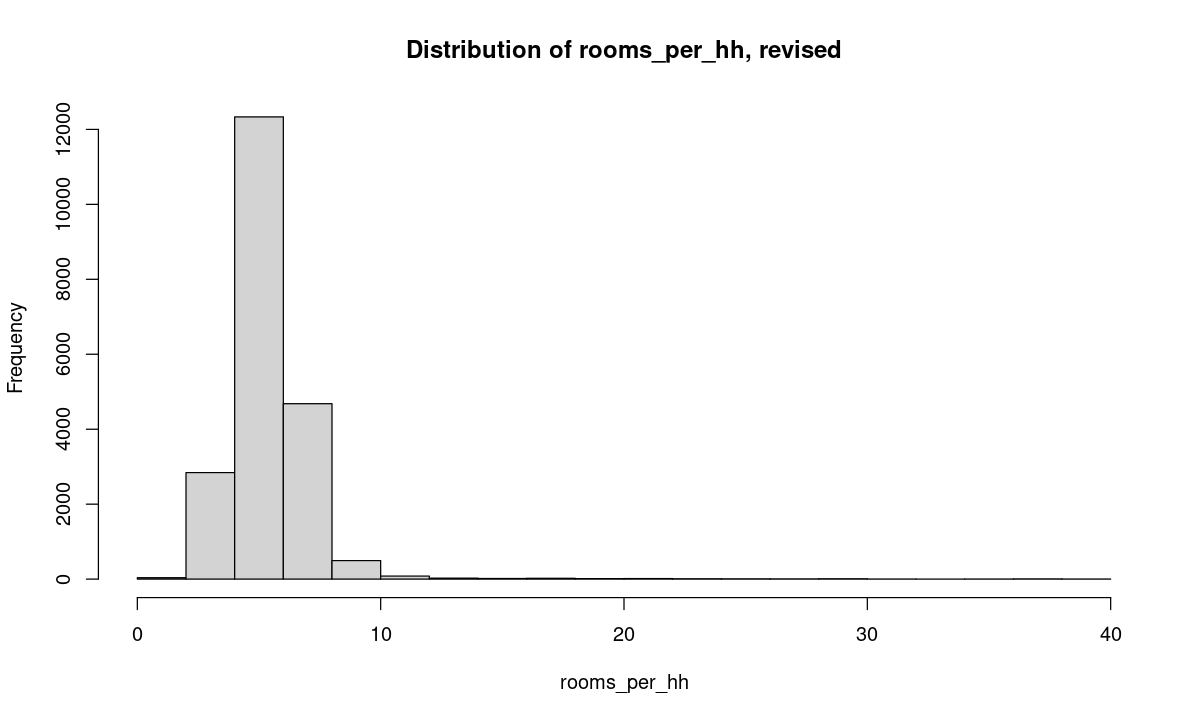

In [75]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$rooms_per_hh, breaks=20, main="Distribution of rooms_per_hh, revised",
     xlab="rooms_per_hh")


### Write to disk

In [77]:
# We currently have 20,603 records.  37 records with
# extreme values have been removed from the dataset.

write.csv(dat, 
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v01.csv",
          row.names=TRUE)


In [78]:
colnames(dat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"

## Attach HHdensity variable

We can increase the power of our models by adding an urbanacity metric---households per square mile---as another predictor.  I do this by bringing in Census data on household density in Census block groups.  Since I was not able to get Census tract data from the 1990 Census (as a direct download), I am using the 2000 Census instead.  Also, since I am not sure that the 2000 Census tracts align with those from the 1990 Census, I use the lat-long for each district in the California housing data to find the nearest year 2000 Census tract and then assign the household density of that tract to its matching district in the California housing data.  

Of course, it would have been preferable to have Census 1990 data since it is from this Census that the California housing dataset is constructed.  Some, or many, of the 1990 districts will have had an HHdensity value quite different from what I am assigning.  This means that my HHdensity predictor will not be as powerful as it could have been. 


In [17]:
# Bring in the semi-prepped data.

hhdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v01.csv",
                row.names=1,
                header=TRUE, colClasses= c("character", rep("numeric", 9), "character",
                                           rep("numeric", 3)))
dim(hhdat)
# 20,603   13


[1] 20603    13

In [18]:
head(hhdat)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_hh,bdrms_per_room,pop_per_hh
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,6.9841,0.14659,2.5556
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,6.2381,0.15580,2.1098
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,8.2881,0.12952,2.8023
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY,5.8174,0.18446,2.5479
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY,6.2819,0.17210,2.1815
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY,4.7617,0.23177,2.1399


In [ ]:
### COMMENT: 

# Unfortunately the CA housing data has highly rounded
# lat-longs; this might lead to some inaccuracies when  
# assigning an HHdensity to each rcd.


### Wrangle Census tract 2000 data

In [11]:
# Load raw data.

# The read.table does not work if we have sep = "\t" (even though the file
# is tab-delimited).
dat <- read.table(file= "/home/greg/datasets/CA_housing/Census2000/ustracts2k/ustracts2k.txt", 
                  sep= "",
                  colClasses = c("character", rep("numeric", 8)))
dim(dat)
# 66304    9


[1] 66304     9

In [12]:
colnames(dat) <- c("code", "population", "households", "landArea_meters", 
                   "waterArea_meters", "land_area_sqMiles", 
                   "water_area_sqMiles", "lat", "long")

newdat <- dat[, c("code", "households", "land_area_sqMiles", "lat", "long")]
newdat[c(1:3, 66302:66304),]
colnames(newdat) <- c("code", "hh_count", "LandArea", "lat", "long")

dat <- newdat
rm(newdat)
dat$state <- substr(dat$code, 1, 2)
head(dat)


,code,households,land_area_sqMiles,lat,long
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AL01001020100,769,3.7750,32.471,-86.487
2,AL01001020200,731,1.2905,32.466,-86.473
3,AL01001020300,1263,2.0869,32.474,-86.458
66302,PR72153750503,873,1.2791,18.027,-66.873
66303,PR72153750601,1785,4.2410,18.019,-66.840
66304,PR72153750602,1273,6.7715,17.996,-66.852


,code,hh_count,LandArea,lat,long,state
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AL01001020100,769,3.7750,32.471,-86.487,AL
2,AL01001020200,731,1.2905,32.466,-86.473,AL
3,AL01001020300,1263,2.0869,32.474,-86.458,AL
4,AL01001020400,1871,2.4657,32.467,-86.446,AL
5,AL01001020500,2277,4.4570,32.455,-86.425,AL
6,AL01001020600,1352,3.2463,32.440,-86.478,AL


In [13]:
# More data cleaning.

dat <- dat[which(dat$state == 'CA'),]

# The LandArea for a census tract is from the 
# land_area_sqMiles field.  I did not add in the water
# area that the census tracts include because I want my 
# urbanacity metric to be land-focused only.
dat <- dat[which(dat$LandArea != 0),]
dim(dat)
# 7049   6


[1] 7049    6

In [14]:
# Construct the urbanacity metric.

dens <- round(dat$hh_count/dat$LandArea, 4)
summary(dens)
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#       0     815    2103    2876    3453   66174 

HHdens_ln <- log(dens + 1)
summary(HHdens_ln)
#   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   0.00    6.70    7.65    7.12    8.15   11.10 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     815    2103    2876    3453   66174 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.70    7.65    7.12    8.15   11.10 

In [15]:
dat$HHdens_ln <- HHdens_ln

write.csv(dat, 
          file="/home/greg/datasets/CA_housing/Census2000/ustracts2k/ustracts2k_wrangled_CA_only.csv.csv", 
          row.names= FALSE)


### Attach HHdensity values to the CA housing dataset

In [19]:
# For the state of California, the following distance
# function should work fairly well.  Distance is in
# miles.  (Different distance functions have different
# degrees of accuracy depending on the location of
# the points on the earth's surface---e.g., location 
# from the equator.)

get_distance <- function(hh_lat, hh_long, blk_lat, blk_long) {
  
  # blk_lat and blk_long are the lat-long for the Census tracts
  a <- hh_lat/57.2957795130824
  b <- hh_long/57.2957795130824
  c <- blk_lat/57.2957795130824
  d <- blk_long/57.2957795130824
  
  x <- ((sin(a)*sin(c))+(cos(a)*cos(c)*cos(b-d)))
  distance <- round(3959 * (2 * atan(1) - asin(x)), 2)
  
  return(distance)
}


In [20]:
# Order the census tract data by longitude, then latitude; this 
# should allow for quicker lookup into this reference dataframe.
dat <- dat[order(dat$long, dat$lat),]

# All of the codes in dat are unique; this allows us to uniquely 
# identify each row in dat, and thus uniquely tag each lat-long 
# combination.
length(dat$code)
# [1] 7049
length(unique(dat$code))
# [1] 7049


[1] 7049

[1] 7049

In [21]:
# Attach HHdens_ln values to the appropriate district
# in hhdat.

hhlats <- hhdat$latitude
hhlongs <- hhdat$longitude
hhdat$HHdens_ln = NA

offsets <- c(0.02, 0.04, 0.08, 0.12, 0.2, 0.3, 0.5, 1)

start <- Sys.time()
for(i in 1:dim(hhdat)[1]) {
  
  curlat <- hhlats[i]
  curlong <- hhlongs[i]
  
  flag <- TRUE
  indx <- 1
  while((flag == TRUE) & (indx <= length(offsets))) {
    
    cur_offset <- offsets[indx]
    indx <- indx + 1
    candidates <- dat[which((dat$long > curlong - cur_offset & dat$long < curlong + cur_offset) &
                              (dat$lat > curlat - cur_offset & dat$lat < curlat + cur_offset)),
                      c("code", "lat", "long")]
    if(nrow(candidates) > 0) {
      flag <- FALSE
    }
  }
  
  if(nrow(candidates) > 0) {
    
    ans <- mapply(get_distance, candidates$lat, candidates$long, curlat, curlong)
    names(ans) <- candidates$code
    
    # Assign the HHdensity of the district that is closest to
    # the CA housing record.
    val <- names(ans[as.numeric(ans) == min(as.numeric(ans))])[1]
    hhdat$HHdens_ln[i] <- as.numeric(dat[which(dat$code == val),]$HHdens_ln)
  }
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.62 secs


Time difference of 6.62 secs

In [22]:
# Make sure there are no missing values.

summary(dat$HHdens_ln)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.70    7.65    7.12    8.15   11.10 

### Save out enhanced CA housing dataset

In [25]:
rm(dat)

write.csv(hhdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
          row.names=TRUE)


In [24]:
colnames(hhdat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"

In [27]:
dat <- hhdat; rm(hhdat)


In [28]:
# Get correlations betw. our current set of variables
# and log(median_house_value).

cols <- colnames(dat)[which(!(colnames(dat) %in% c("ocean_proximity")))]

tmpdat <- dat[, cols]
tmpdat$median_house_value <- log(tmpdat$median_house_value)
tmpdat$population <- log(tmpdat$population)
tmpdat$total_bedrooms <- log(tmpdat$total_bedrooms)
tmpdat$total_rooms <- log(tmpdat$total_rooms)

ans <- as.data.frame(cor(tmpdat[, ])[, "median_house_value"])
colnames(ans) <- c("median_house_value")
round(ans[order(ans$median_house_value, decreasing = TRUE), , 
          drop = FALSE], 3)
                     

,median_house_value
,<dbl>
median_house_value,1.000
median_income,0.659
HHdens_ln,0.276
total_rooms,0.186
rooms_per_hh,0.172
households,0.098
total_bedrooms,0.086
housing_median_age,0.075
population,0.026


In [ ]:
### COMMENTS:

# Notice that after median_income, HHdens_ln is the 
# variable most highly correlated with median_house_value.

# Notice the weak linear correlation between longitude
# and median_house_value.  Something is amiss here because
# we already know from the ocean_proximity summaries above
# that districts' median house values increase as we move
# west from INLAND to OCEAN districts.  We would expect 
# longitude's correlation with median_house_value to be
# even stronger than that of latitude's.


## Transform longitude so that it has stronger correlation with median_house_value

The linear correlation between longitude and log(median_house_value) is -2.3%.  But for latitude this same correlation is -19.3%, more than an eight-fold increase.  Yet the ranges for the two variables are equal: latitude's range is just shy of 10 degrees, whereas longitude's is exactly 10 degrees.  Why such a large difference in the correlation, then?  Shouldn't the correlation between longitude and median house value also be at least -19%?  In fact, we would expect it to be stronger than -19% because the data shows very clearly that as we move toward the ocean, median house prices tend to increase.  The trend isn't nearly so strong as we move from north to south.  (Although north of the 39th parallel, median home values drop significantly, only around 5% of the records in the dataset are north of the 39th parallel.)

Is there a transformation we can apply to longitude so that it has at least as strong a linear correlation with the response as latitude?  It turns out that there is.


                                        * * * * *


A look at the shape of the state of California shows us why longitude under-performs in this state.  California basically has parallel east-west borders (in the sense that the distance between these two borders remains about the same as we move from north to south) and, roughly-speaking, parallel north-south borders.  But south of the 39th parallel, the state veers to the right.  In Lake Tahoe there is a point of rotation: exactly 39 degrees north and 120 degrees west.  Below the 39th parallel, the oceanside border of California is roughly parallel to the inland border with Nevada.  Thus, if California can be straightened into a rectangle using the point of rotation just mentioned, each longitudinal should carry the same information throughout the state, namely the distance from the ocean, when trying to predict median house values.

When longitude is transformed to change the shape of California in this way, its linear correlation with median_house_value increases 23X, making longitude second only to median_income in this measure.  With longitude newly transformed, one can model the dataset with latitude, longitude, median income, housing median age, and 4 other variables for a 70% R-sqrd AND do so without bringing ocean_proximity into the model.  This new transformation for longitude thus adds to our options for model selection because we can still have a strong model without relying on the categories of ocean_proximity; all or our model terms can then be numeric.


In [29]:
# Code for transforming longitude into a much stronger predictor.

#################################################

# Apply transformation to all longitudes tied to any latitude < 39.00.

# The formula is as follows: 

# origin at Lake Tahoe: (39.00, -120.00)
# origin oceanside: (39.00, -123.684)

# delta.lat = 39.00 - lat
# slope = 1.086706
# delta.long = slope * delta.lat = 1.086706 * (39 - lat)
# new.long = original.long - delta.long = long - [1.086706 * (39 - lat)]

#################################################


origLats <- dat$latitude
origLongs <- dat$longitude

summary(origLongs)
# Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
# -124    -122    -118    -120    -118    -114 

# Transform longitude:
for(i in 1:length(origLats)) {
  if(origLats[i] < 39) {
    origLongs[i] <- origLongs[i] - (1.086706 * (39 - origLats[i]))
  } 
}

summary(origLongs)
# Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
# -125    -124    -124    -123    -123    -119


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -124    -122    -118    -120    -118    -114 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -125    -124    -124    -123    -123    -119 

In [30]:
# Create a new column for the transformed longitude data.

dat$long_transf <- origLongs

# make the predictor positive
dat$long_transf <- dat$long_transf + 127

rm(origLats, origLongs)


In [31]:
# Get new set of correlations.

cols <- colnames(dat)[which(!(colnames(dat) %in% c("ocean_proximity","longitude")))]

tmpdat <- dat[, cols]
tmpdat$median_house_value <- log(tmpdat$median_house_value)
tmpdat$population <- log(tmpdat$population)
tmpdat$total_bedrooms <- log(tmpdat$total_bedrooms)
tmpdat$total_rooms <- log(tmpdat$total_rooms)

ans <- as.data.frame(cor(tmpdat[, ])[, "median_house_value"])
colnames(ans) <- c("median_house_value")
round(ans[order(ans$median_house_value, decreasing = TRUE), , 
          drop = FALSE], 3)


,median_house_value
,<dbl>
median_house_value,1.000
median_income,0.659
HHdens_ln,0.276
total_rooms,0.186
rooms_per_hh,0.172
households,0.098
total_bedrooms,0.086
housing_median_age,0.075
population,0.026


In [ ]:
### COMMENT: 

# The transformation increases the linear correlation with
# log(median_house_value) 23X, from -2.3% to -53%.

# For linear modeling, this is a big deal.  It essentially 
# obviates the need for the ocean_proximity categorical 
# predictor.


### Write to disk

In [32]:
# Here I overwrite housing_cleaned_v02.csv.

write.csv(dat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
          row.names=TRUE)
dim(dat)


[1] 20603    15

In [33]:
colnames(dat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

# Section 2: Impute values for censored data

housing_median_age is capped at 52 years, and median_house_value is capped at \$500K.  Around 10\% of the records have censored data.  When modeling, we are not doing ourselves any favors by throwing out this amount of data; nor are we doing ourselves any favors by keeping the records with the censored data, but at the capped values.  The  best approach is to impute values, assuming we have a good method for doing so.  This is especially true for median_house_value, since it is our response variable and we want our models to accurately predict median house values.  (housing_median_age also has less importance because age is only a very weak predictor of median_house_value.)  The censored values, if not properly treated, add noise to the data, making it more difficult to obtain accurate predictions.  Ideally, we want our models to accurately predict median_house_value even when a district has a median house value >= 500K since such districts actually exist in our dataset.

Andrew Gelman and Jennifer Hill offer several closely related approaches for addressing censored data in Section 18.5 of their book, *Data Analysis Using Regression and Multilevel/Heirarchical Models*.  I follow their method of using a Gibbs sampler.  The process for imputing values for housing_median_age is worked out in Appendix A.  The process for imputing values for median_house_value is found in Appendix B.  This section tackles some of the preliminaries.

I first impute values for the records with a censored housing_median_age since I use this variable as a predictor when modeling the response variable, median_house_value.  The first step is to find a model for predicting housing_median_age.  Some of the steps in model selection are shown below.  Once we have imputed values for housing_median_age, we can follow a similar process for imputing values for the censored median_house_values.



                                        * * * * *
                                        

I am imputing values prior to constructing training and test sets because I do not want to impute values when applying cross-validation methods.  Not only would that be messy, I am not sure it even makes sense since there are no true (i.e., observed) values (above 52 years of age; above \$500K) to work with for getting rmse scores.  

For the purpose of finding a "best" predictive model for median_house_value given the predictors we have, it is best to impute values for the censored data because (i) if we keep the capped values as is, we will get a false sense of what our models can actually do; the models perform much worse with the capped values, and this will be especially true for a linear model; yet, (ii) if we remove the records with censored values, we also get a false sense of model performance for ALL Census districts in California.  If we remove the records with censored values, we are discarding valuable information.  

Including imputed values in our data, however, means that for the purposes of getting rmse scores for model comparison, *we need to treat the imputed values as we do the non-censored data, i.e., as if they are true, or observed*.  When comparing model scores, this presents no issue.  It is only when we look at a score by itself that we have to be cautious; e.g., if a model rmse score is 75K we have to keep in mind that around 20K of this error is due to including predictions for the range of imputation.  Although only 4.8\% of the median house value data has been imputed, the imputed values are in a range for which we have the least amount of information and for which the median values are greatest.  Error scores are thus greatly inflated when we work with all of the data at once.  This means, among other things, that if we want a prediction for a district which we *know* will have a median house value below, say, 150K, and we need an error estimate for the prediction, we should estimate the error using test data which only includes districts with a median house value <= 150K.  (For this example we should expect an rmse score much closer to 35K than to 75K.)



                                       * * * * *



In [3]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
# Get percent of records with censored data.

tmpdat <- dat[which((dat$median_house_value >= 500000) | (dat$housing_median_age >= 52)),]
ans <- 100*round(nrow(tmpdat)/nrow(dat), 3)
paste0("Percent of data that has a cap: ", as.character(ans))
# 'Percent of data that has a cap: 10.1'

# Thus, around 2,081 records have censored data.


[1] "Percent of data that has a cap: 10.1"

In [5]:
# Get percent of records with censored data for median_house_value.

tmpdat <- dat[which(dat$median_house_value >= 500000),]
ans <- 100*round(nrow(tmpdat)/nrow(dat), 3)
paste0("Percent of median_house_value rcds that are censored: ", as.character(ans))
# 'Percent of median_house_value rcds that are censored: 4.8'

# Thus, around 987 records have median_house_value censored at 500K.


[1] "Percent of median_house_value rcds that are censored: 4.8"

In [ ]:
### NOTE:

# Around 60 records, or 0.3% of the districts appear to
# be censored at either $350K or $450K.  I will not
# worry about imputing values for these districts.


In [6]:
# Get percent of records with censored data for housing_median_age.

tmpdat <- dat[which(dat$housing_median_age >= 52),]
ans <- 100*round(nrow(tmpdat)/nrow(dat), 3)
paste0("Percent of rcds that have censored housing_median_age: ", as.character(ans))
# 'Percent of rcds that have censored housing_median_age: 6.2'


[1] "Percent of rcds that have censored housing_median_age: 6.2"

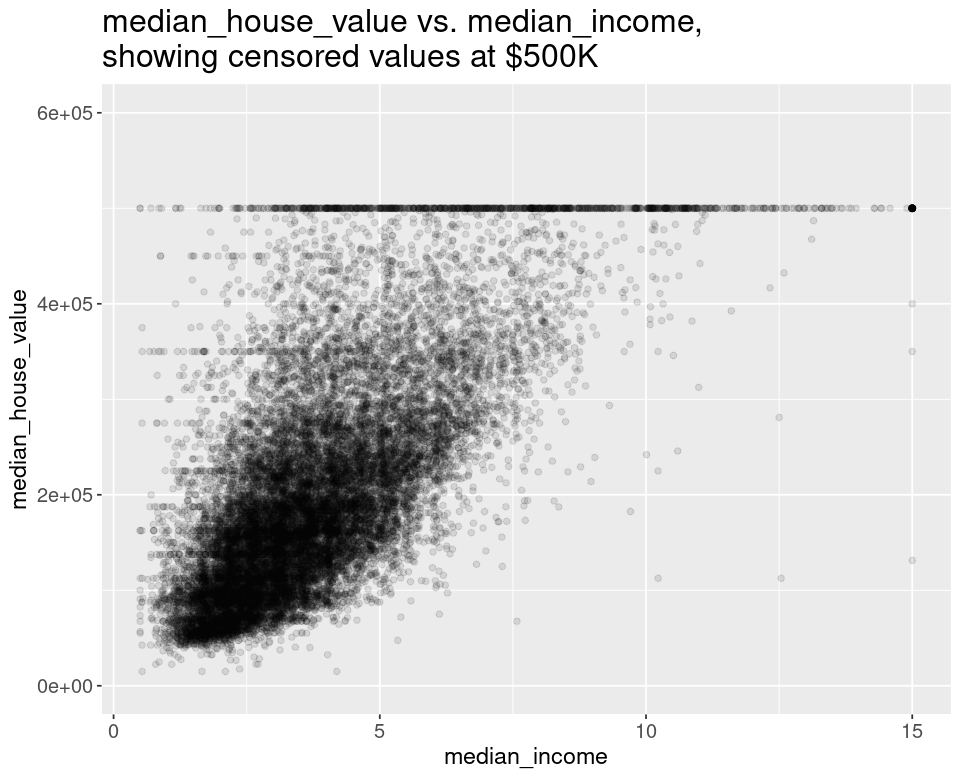

In [7]:
# Plot of median_house_value vs. median_income (the most
# important predictor).  4.8% of the data is censored at
# $500K.

options(repr.plot.width= 8, repr.plot.height= 6.5)

p <- ggplot(dat, aes(median_income, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("median_income") + ylab("median_house_value") +
  ggtitle("median_house_value vs. median_income, 
showing censored values at $500K") + ylim(0, 6e+05) +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


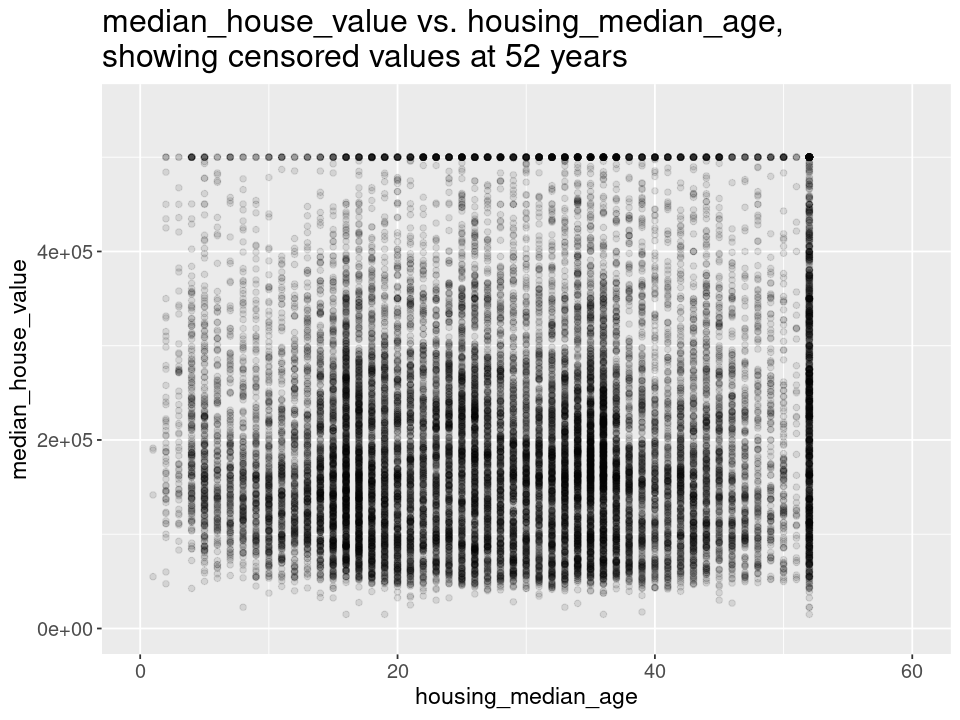

In [8]:
# Plot of median_house_value vs. housing_median_age. 
# 6.15% of the data is censored at age 52.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(housing_median_age, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("housing_median_age") + ylab("median_house_value") +
  ggtitle("median_house_value vs. housing_median_age, 
showing censored values at 52 years") + xlim(0, 60) + ylim(0, 5.5e+05) +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


## Construct a model for imputing housing_median_age

The actual imputation for the censored housing_median_age values is done in Appendix A.  The steps taken to construct the model used for that imputation are shown here.

In [50]:
colnames(dat)
summary(dat$housing_median_age)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    28.6    37.0    52.0 

In [4]:
# Initial model for age imputation.  Note that median_house_value
# is a predictor in this model; it has censored data.

# Weighted Least Squares (WLS) works well.  The weights help
# us avoid non-constant variance.

a01 <- lm(housing_median_age ~ long_transf + latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(log(total_rooms)) +
            I(log(total_bedrooms)) + 
            I(population^0.05) +
            I(households^0.25) +
            I(households^0.5) +
            households +
            I(sqrt(median_income)) +
            I(sqrt(median_house_value)) +
            median_house_value +
            ocean_proximity + 
            HHdens_ln +
            I(HHdens_ln^2) + 
            bdrms_per_room + 
            I(bdrms_per_room^2) +
            I(sqrt(pop_per_hh)) +
            rooms_per_hh +
            latitude:long_transf +
            ocean_proximity:latitude +
            ocean_proximity:latitude:long_transf,
          data= dat, weights= dat$households^0.39)
ans <- summary(a01); 
ans[[1]] <- ""; round(ans$adj.r.squared, 3)
# Adj. R-sqrd of 43.5%


[1] 0.433

In [5]:
# Check for constant variance.

ncvTest(a01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0013839, Df = 1, p = 0.97

In [6]:
# Check for curvature, namely linearity with respect to
# the fitted values (since obtaining linearity with respect
# to each of the terms is too difficult).

# The Tukey test passes.  This means a01 has linearity
# with respect to the fitted values.

residualPlots(a01, plot= FALSE)


                            Test stat Pr(>|Test stat|)
long_transf                     -2.90          0.00370
latitude                        -3.58          0.00035
I(latitude^2)                   -3.27          0.00109
I(latitude^3)                   -3.23          0.00124
I(latitude^4)                   -3.28          0.00104
I(log(total_rooms))              3.93          8.5e-05
I(log(total_bedrooms))           1.75          0.08078
I(population^0.05)              -1.40          0.16012
I(households^0.25)              -4.87          1.1e-06
I(households^0.5)                6.16          7.6e-10
households                      -7.50          6.9e-14
I(sqrt(median_income))           5.46          4.9e-08
I(sqrt(median_house_value))     -2.28          0.02252
median_house_value              -3.15          0.00162
HHdens_ln                        3.52          0.00044
I(HHdens_ln^2)                   0.67          0.50597
bdrms_per_room                  -5.48          4.2e-08
I(bdrms_pe

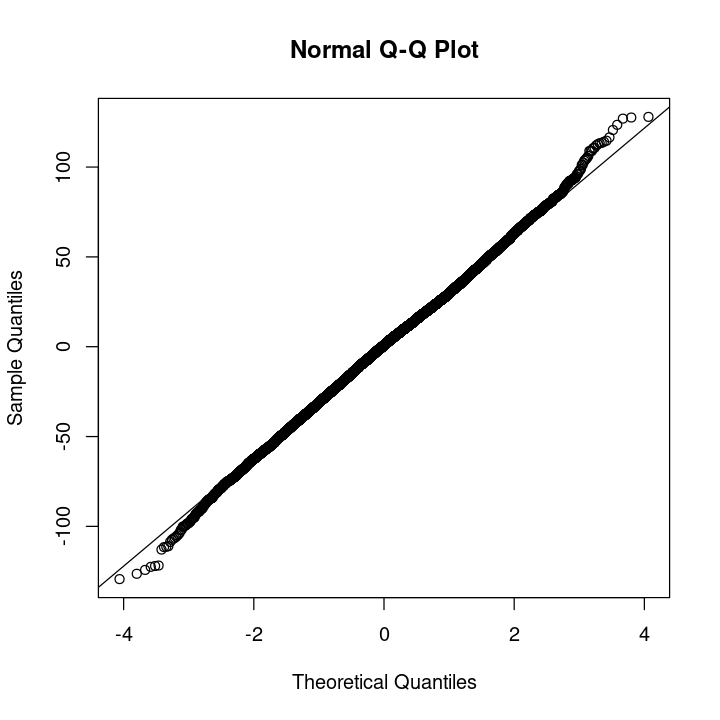

In [66]:
# Because of the weights, we need to use pearson residuals.

options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a01, type= "pearson"))
qqline(residuals(a01, type= "pearson"))


In [7]:
# With 31 coefficients in the model, the Gibbs sampler
# has a lot of work to do.  

dim(ans$coefficients)[1]
# 31


[1] 31

In [8]:
# We can greatly reduce the number of coefficients if we
# model without using ocean_proximity.  (The adjusted
# R-sqrd drops by 3.2%.)

a02 <- lm(housing_median_age ~ long_transf + latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(log(total_rooms)) +
            I(log(total_bedrooms)) + 
            I(population^0.25) +
            I(households^0.4) +
            I(sqrt(median_income)) +
            I(sqrt(median_house_value)) +
            median_house_value +
            HHdens_ln +
            I(HHdens_ln^2) + 
            bdrms_per_room + 
            I(bdrms_per_room^2),
          data= dat, weights= dat$households^0.52)
a02.summary <- summary(a02); 
a02.summary[[1]] <- ""; a02.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-183.49  -33.07    1.03   31.44  212.95 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)
(Intercept)                 -7.33e+04   5.59e+03  -13.12  < 2e-16
long_transf                 -2.89e+00   1.36e-01  -21.35  < 2e-16
latitude                     8.01e+03   6.15e+02   13.03  < 2e-16
I(latitude^2)               -3.27e+02   2.53e+01  -12.90  < 2e-16
I(latitude^3)                5.92e+00   4.63e-01   12.78  < 2e-16
I(latitude^4)               -4.01e-02   3.17e-03  -12.67  < 2e-16
I(log(total_rooms))         -4.20e+01   2.78e+00  -15.11  < 2e-16
I(log(total_bedrooms))       3.90e+01   2.71e+00   14.39  < 2e-16
I(population^0.25)           1.04e+00   1.96e-01    5.32  1.1e-07
I(households^0.4)           -1.17e+00   8.53e-02  -13.73  < 2e-16
I(sqrt(median_income))      -1.02e+01   3.30e-01  -30.78  < 2e-16
I(sqrt(median_house_value)) -7.92e-02   4.31e-03  -18.39  < 2e-16
median_house_v

In [9]:
ncvTest(a02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0404, Df = 1, p = 0.841

In [10]:
residualPlots(a02, plot= FALSE)


                            Test stat Pr(>|Test stat|)
long_transf                     -4.70          2.6e-06
latitude                        -6.40          1.6e-10
I(latitude^2)                   -5.69          1.3e-08
I(latitude^3)                   -5.14          2.7e-07
I(latitude^4)                   -4.81          1.5e-06
I(log(total_rooms))              3.91          9.3e-05
I(log(total_bedrooms))           5.11          3.2e-07
I(population^0.25)               0.24            0.810
I(households^0.4)                5.94          3.0e-09
I(sqrt(median_income))           1.78            0.075
I(sqrt(median_house_value))     -4.16          3.2e-05
median_house_value              -4.70          2.6e-06
HHdens_ln                        8.02          1.1e-15
I(HHdens_ln^2)                   9.03          < 2e-16
bdrms_per_room                  -7.21          5.7e-13
I(bdrms_per_room^2)             -5.61          2.1e-08
Tukey test                      -0.49            0.621


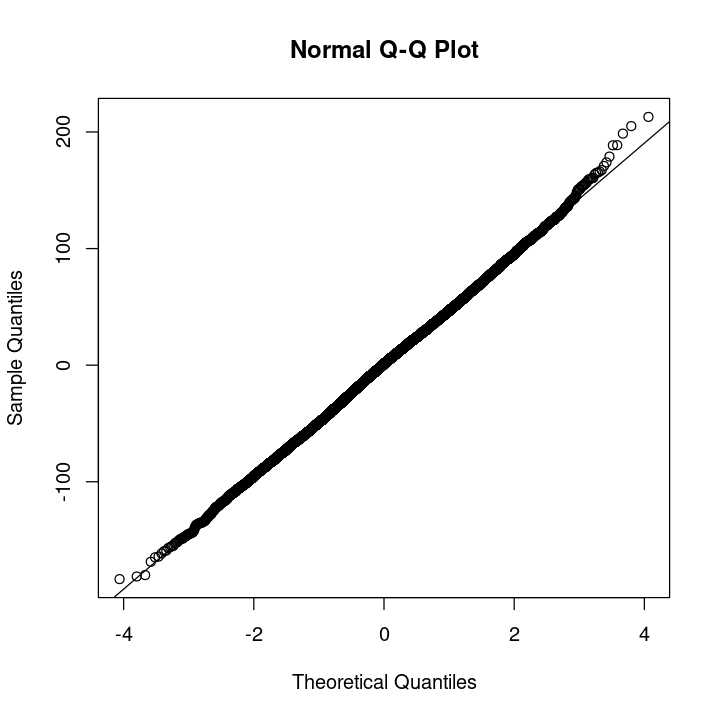

In [104]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a02, type= "pearson"))
qqline(residuals(a02, type= "pearson"))


In [ ]:
### COMMENT:

# The a02 model can still be improved.  Some of the predictors
# used in the model are highly correlated: population is highly
# correlated with households; median_income is highly correlated
# with median_house_value; and bdrms_per_room is highly correlated
# with median_income.


In [11]:
# Create data for checking correlations.  Leave out latitude
# and long_transf terms since I know I want these predictors 
# in the model.

tmpdat <- dat[, c("housing_median_age","total_rooms","total_bedrooms",
                  "population","households","median_income",
                  "median_house_value","HHdens_ln","bdrms_per_room")]


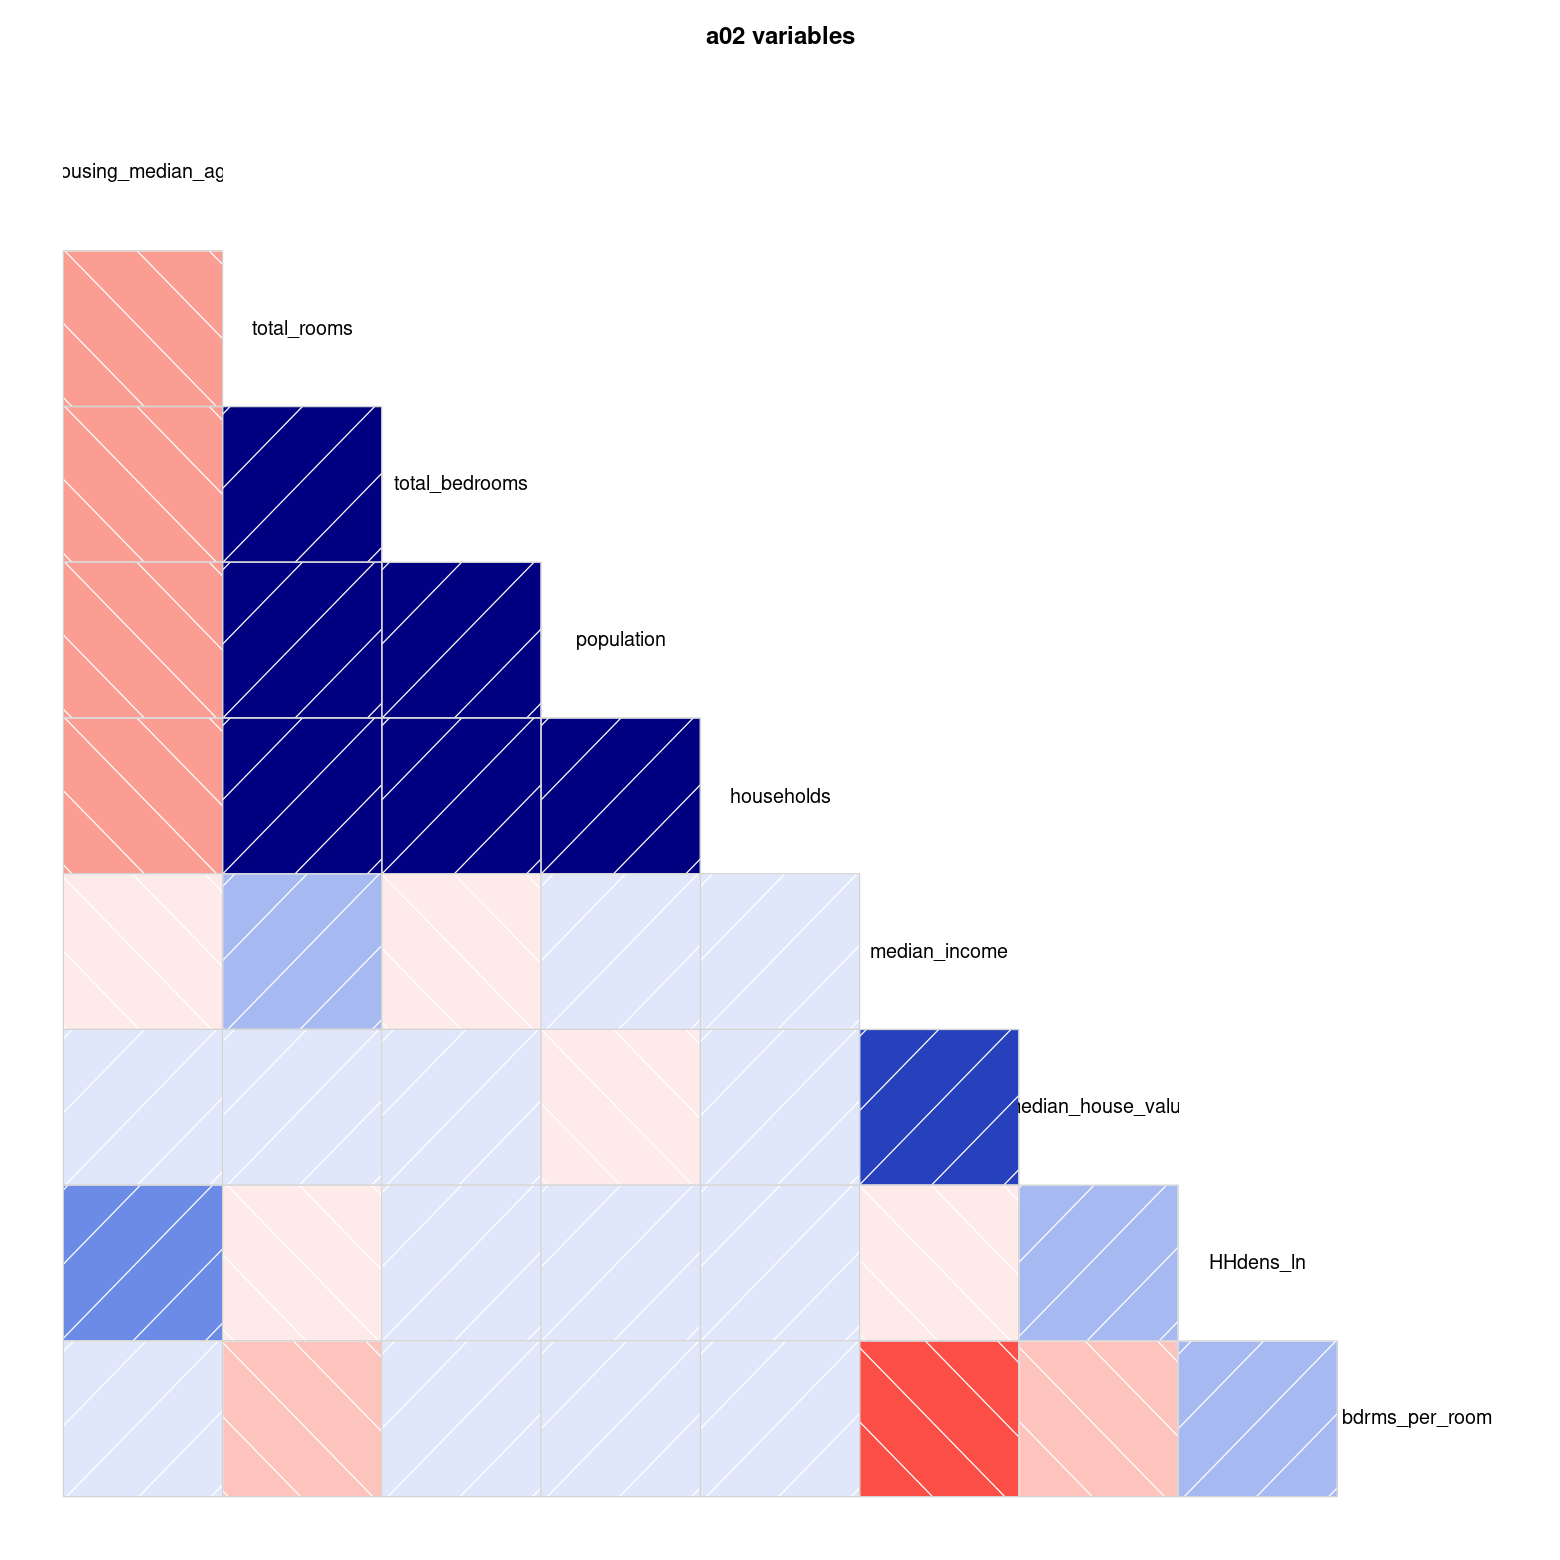

In [14]:
# Darker colors represent higher correlations.  Blue is for
# positive correlations; red is for negative correlations.

options(repr.plot.width= 13, repr.plot.height= 13)

# The following function is from package corrgram.
corrgram(tmpdat, lower.panel=panel.shade, upper.panel=NULL,
        text.panel=panel.txt, main="a02 variables", cex=1.5)


In [15]:
# Correlation between households and population:

print(round(cor(tmpdat$households, tmpdat$population), 3))
# [1] 0.912


[1] 0.912


In [16]:
# Correlation between households and total_rooms:

print(round(cor(tmpdat$households, tmpdat$total_rooms), 3))
# [1] 0.919


[1] 0.919


In [17]:
# Correlation between population and total_rooms:

print(round(cor(tmpdat$population, tmpdat$total_rooms), 3))
# [1] 0.862


[1] 0.862


In [18]:
# I could replace population and households with pop_per_hh.
# pop_per_hh is not highly correlated with total_rooms.
# But I am using weights based on households, so should
# probably keep households in the model.  Also when I model
# with pop_per_hh, the term has a p-value of 0.73.

print(round(cor(dat$pop_per_hh, dat$total_rooms), 3))
# -0.109


[1] -0.109


In [113]:
print(round(cor(dat$households, dat$total_bedrooms), 3))
# 0.975


[1] 0.975


In [20]:
# If we include households in the model, we ought to
# exclude total_bedrooms, total_rooms, and population.
# Otherwise we have collinearity, which can greatly
# increase the standard errors for our coefficient 
# estimates.


# bdrms_per_room is difficult to add to the model and still
# maintain linearity with respect to the fitted values.  So
# it, too, does not appear in a03.

a03 <- lm(housing_median_age ~ 

            I(long_transf^-1) +
            I(long_transf^-1.5) +
          
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
          
            I(households^0.55) +
            I(households^1.1) +
          
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
          
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
          data= dat, weights= dat$households^0.55)

## REMINDER: dat has censored housing_median_age values.

a03.summary <- summary(a03); 
a03.summary[[1]] <- ""; a03.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-229.00  -36.97    1.64   35.26  239.57 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -8.92e+04   5.71e+03   -15.6   <2e-16
I(long_transf^-1)           4.43e+02   1.78e+01    24.9   <2e-16
I(long_transf^-1.5)        -4.93e+02   2.13e+01   -23.1   <2e-16
latitude                    9.73e+03   6.28e+02    15.5   <2e-16
I(latitude^2)              -3.97e+02   2.59e+01   -15.3   <2e-16
I(latitude^3)               7.19e+00   4.73e-01    15.2   <2e-16
I(latitude^4)              -4.88e-02   3.23e-03   -15.1   <2e-16
I(households^0.55)         -6.26e-01   1.96e-02   -31.9   <2e-16
I(households^1.1)           2.73e-03   2.15e-04    12.7   <2e-16
I(median_house_value^0.48)  2.69e-01   1.05e-02    25.7   <2e-16
I(median_house_value^0.24) -1.04e+01   3.97e-01   -26.2   <2e-16
I(HHdens_ln^1.35)          -9.87e-01   7.66e-02   -12.9   <2e-16
I(HHdens_ln^2.7)           

In [21]:
ncvTest(a03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.13688, Df = 1, p = 0.711

In [22]:
residualPlots(a03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -6.43          1.3e-10
I(long_transf^-1.5)            -6.53          6.7e-11
latitude                      -10.83          < 2e-16
I(latitude^2)                  -9.83          < 2e-16
I(latitude^3)                  -8.94          < 2e-16
I(latitude^4)                  -8.36          < 2e-16
I(households^0.55)             -8.07          7.2e-16
I(households^1.1)               5.08          3.8e-07
I(median_house_value^0.48)     -5.82          5.9e-09
I(median_house_value^0.24)     -7.61          2.8e-14
I(HHdens_ln^1.35)               7.57          3.8e-14
I(HHdens_ln^2.7)                5.70          1.2e-08
Tukey test                      0.05             0.96


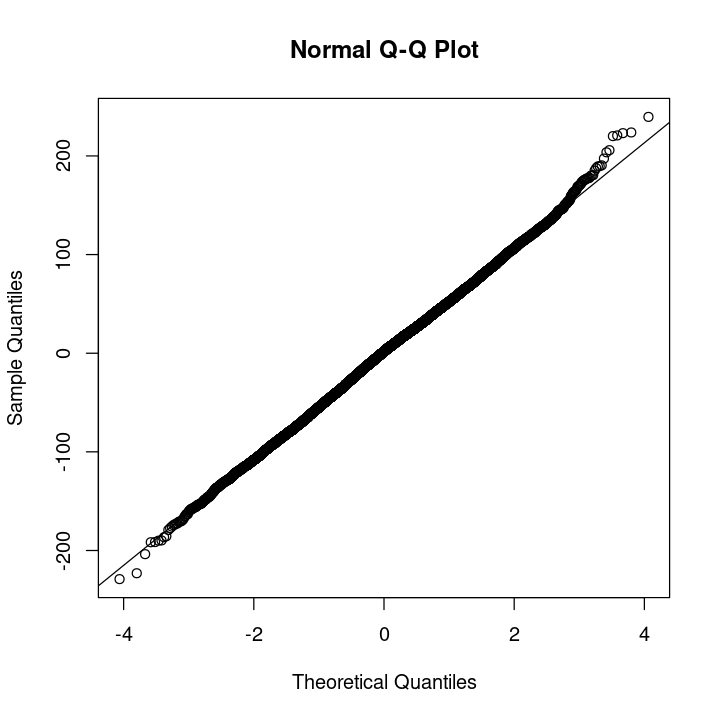

In [160]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a03, type= "pearson"))
qqline(residuals(a03, type= "pearson"))


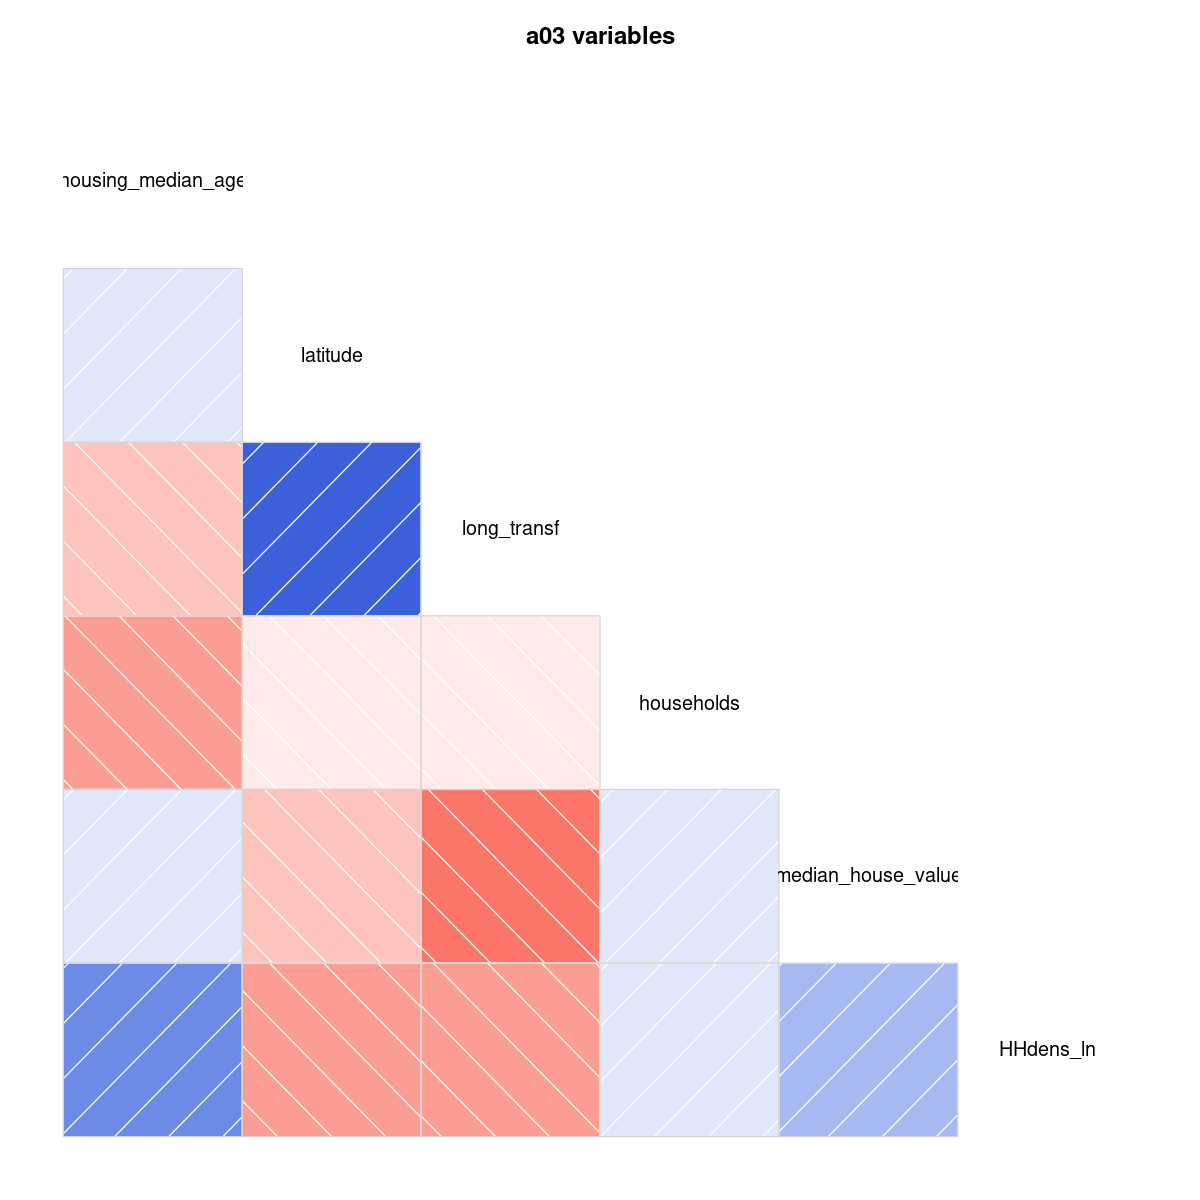

In [157]:
# Another check for correlation betw. the predictors, and
# the degree of correlation with the response variable.

tmpdat <- dat[, c("housing_median_age","latitude","long_transf",
                  "households","median_house_value",
                  "HHdens_ln")]

options(repr.plot.width= 10, repr.plot.height= 10)

# The following function is from package corrgram.
corrgram(tmpdat, lower.panel=panel.shade, upper.panel=NULL,
        text.panel=panel.txt, main="a03 variables", cex=1.5)


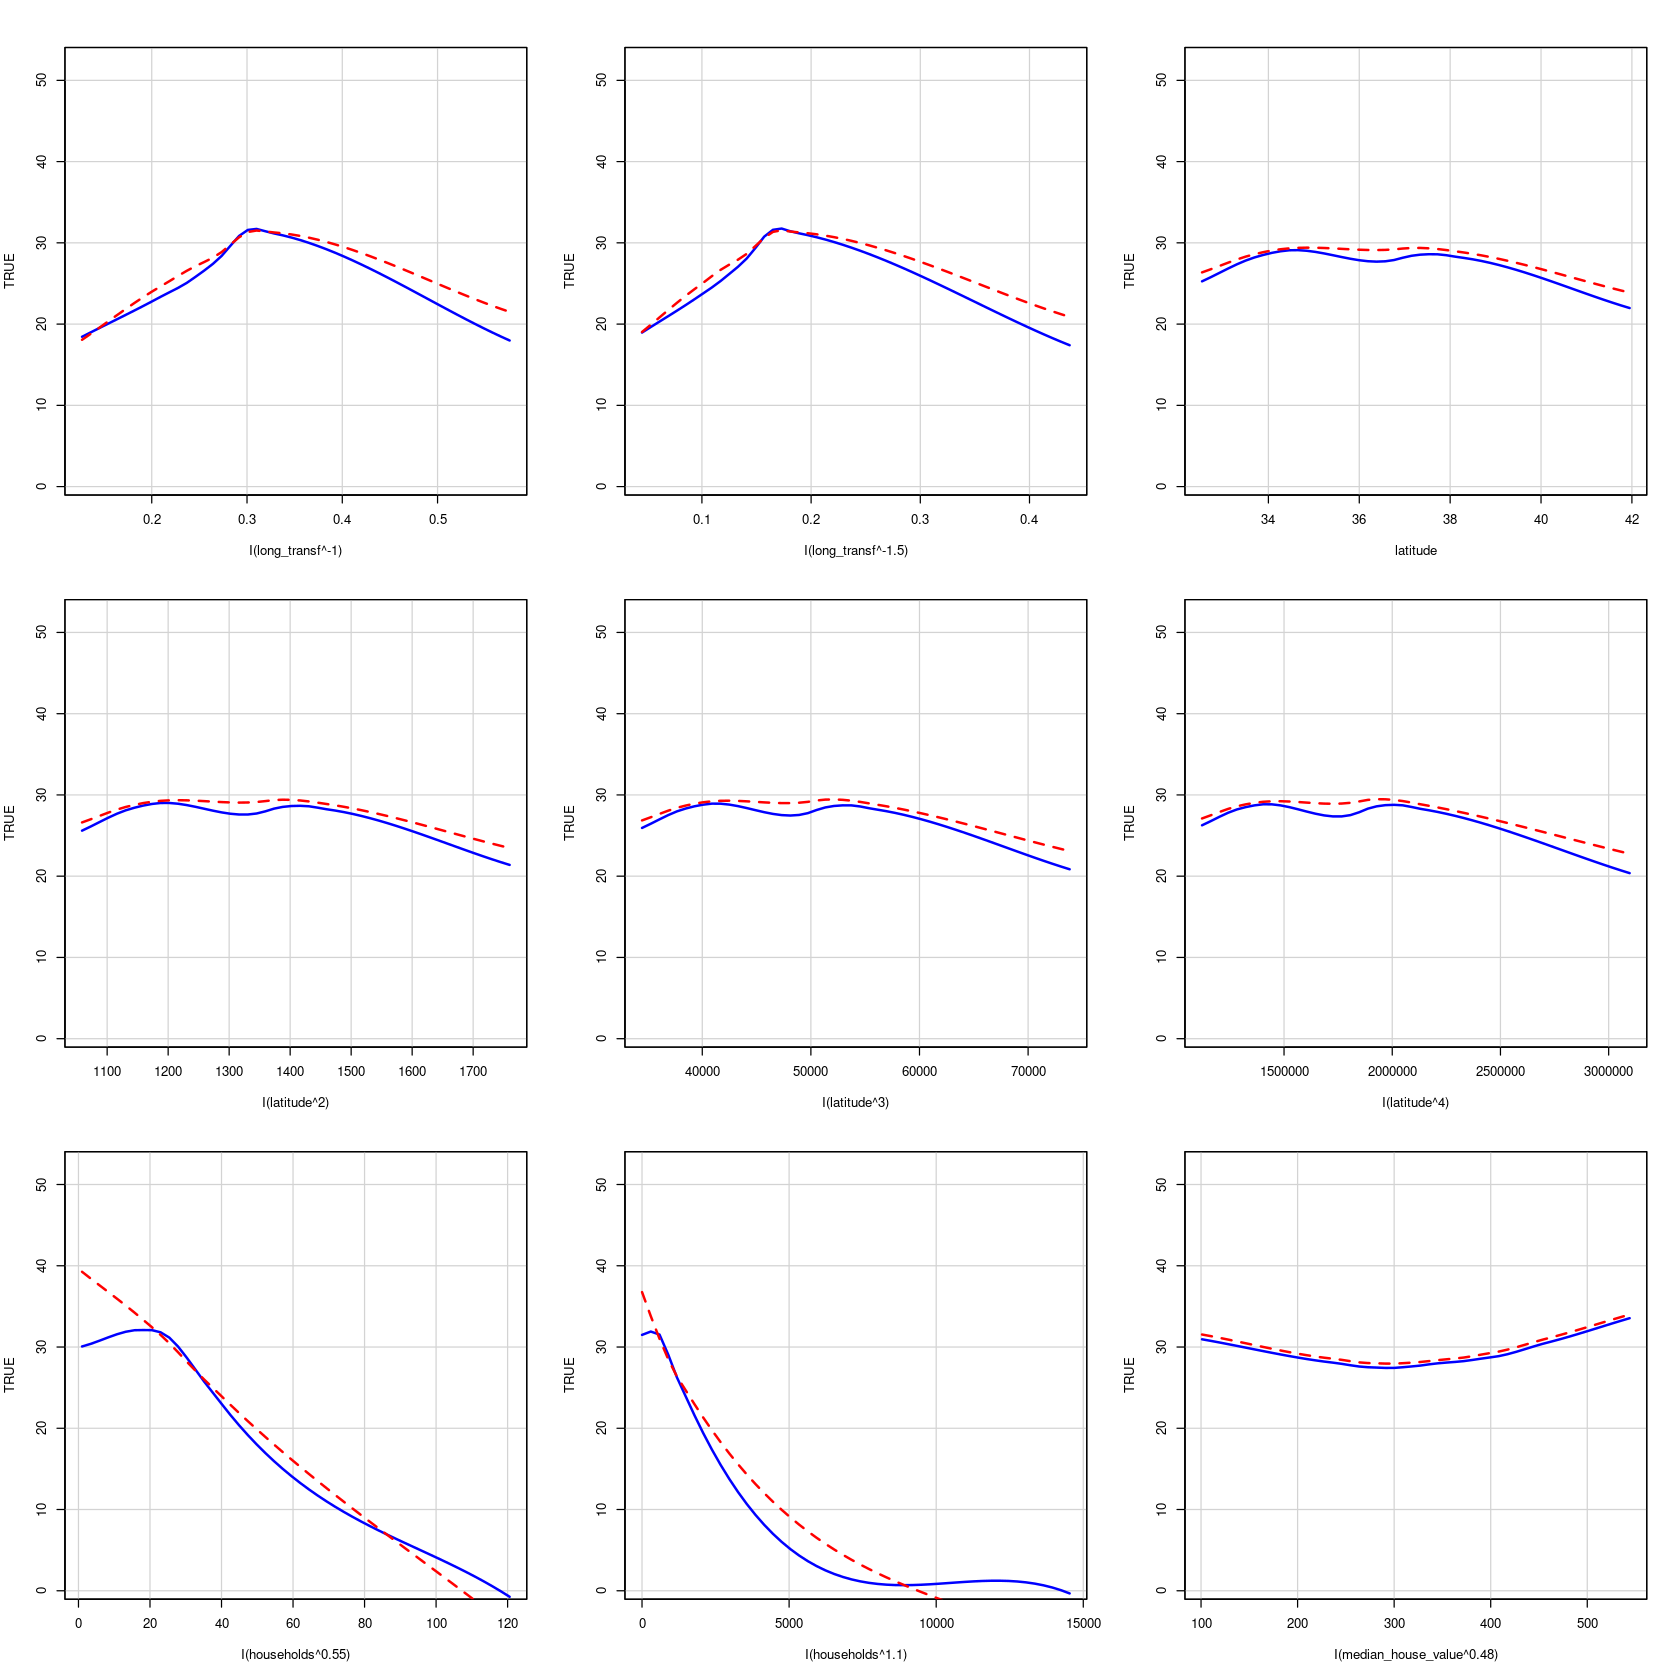

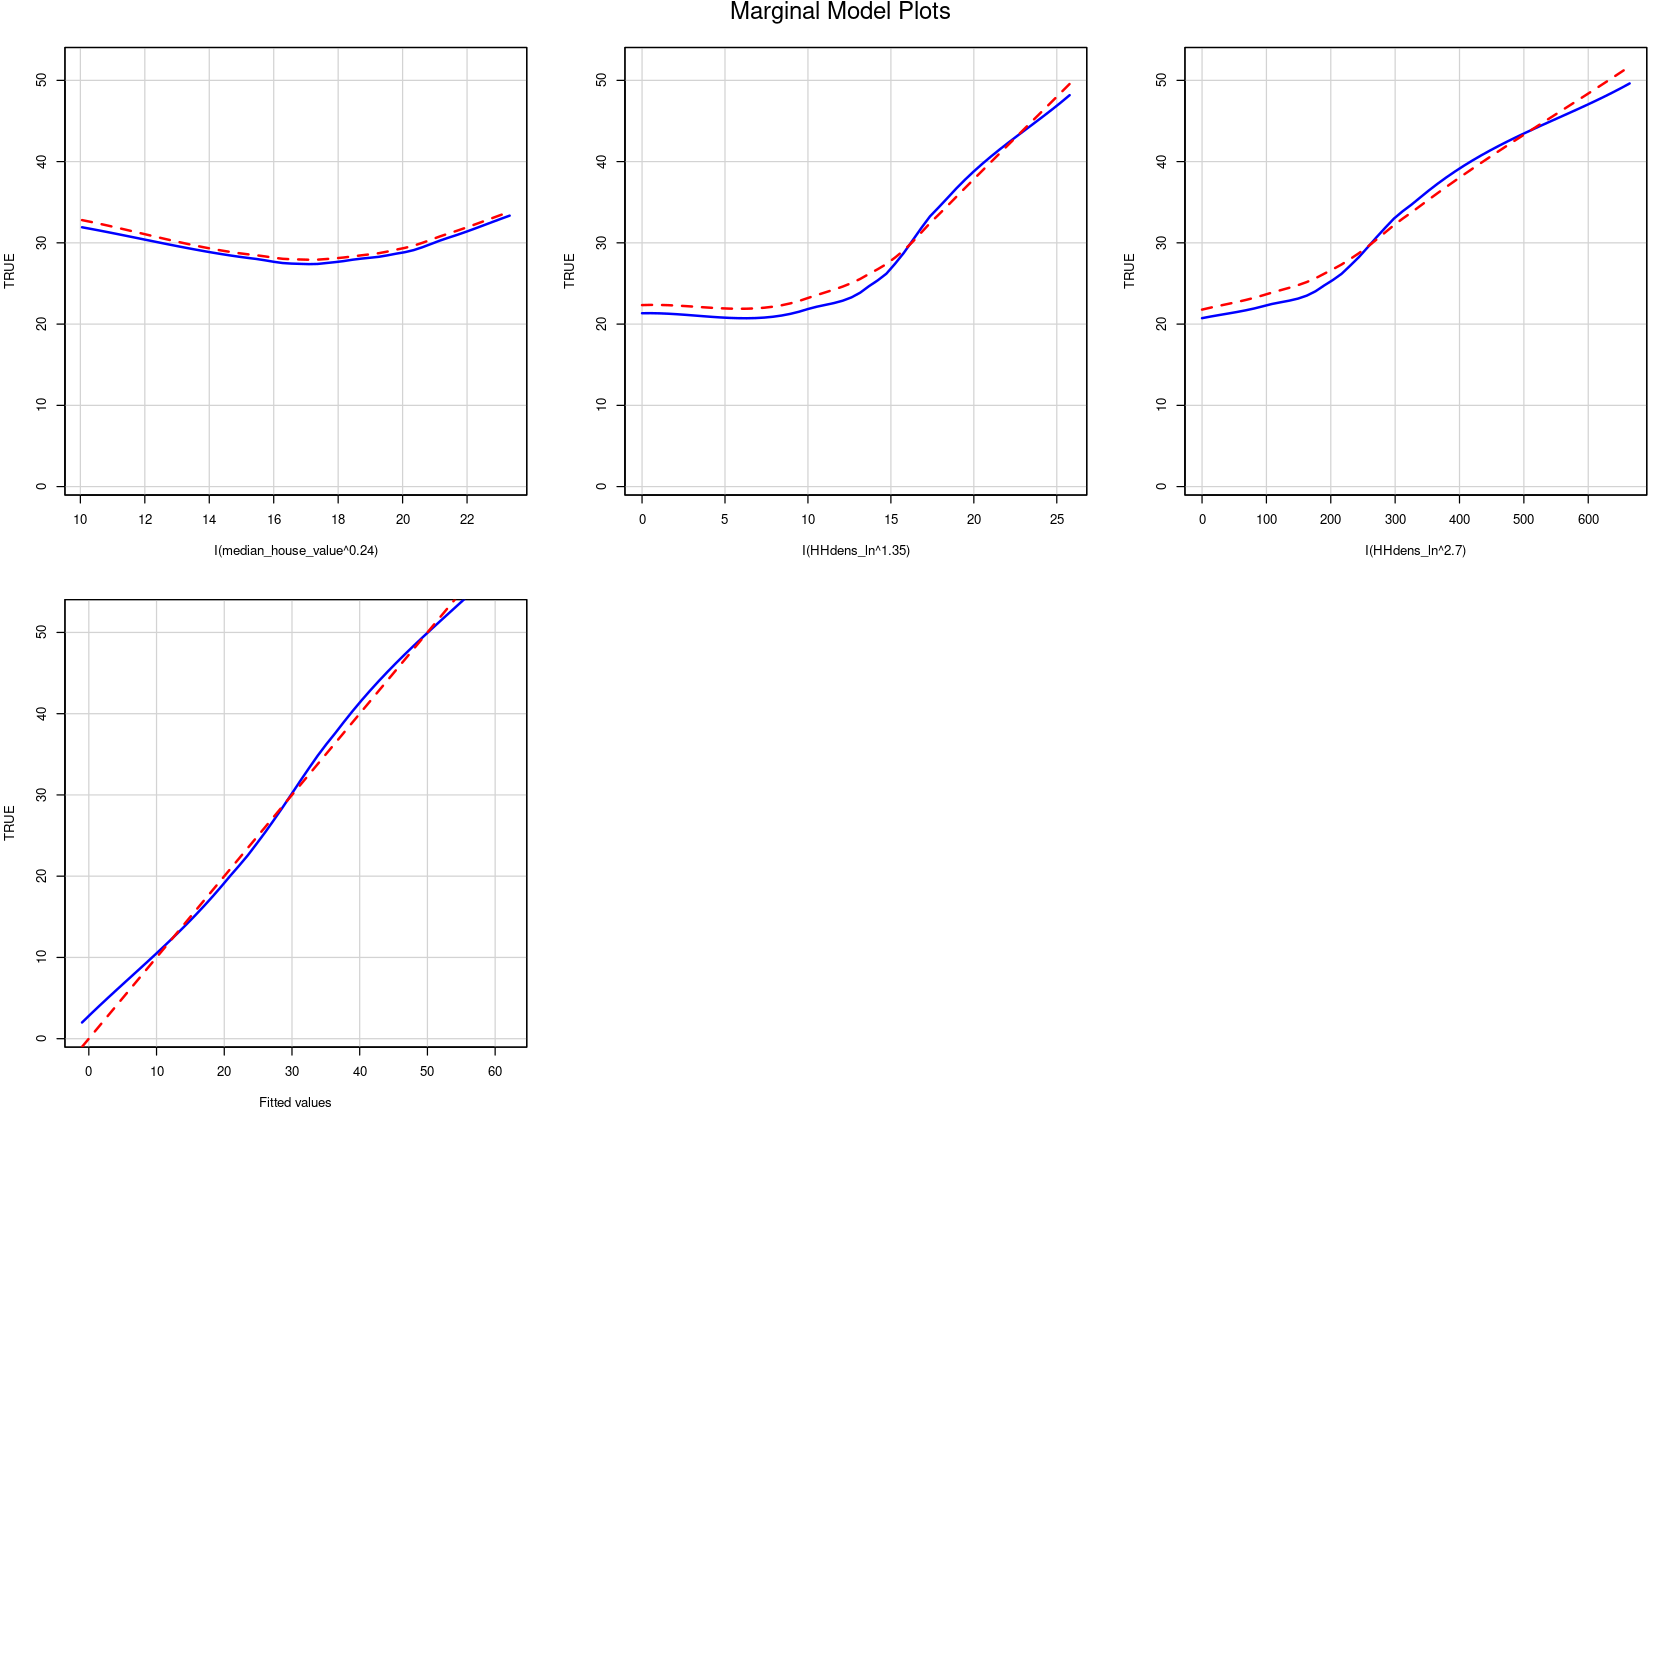

In [158]:
# The a03 model was a bit of a challenge to tune.
# Here are the marginal model plots that helped me
# find the power transformations that I used.

options(repr.plot.width= 14, repr.plot.height= 14)

# blue= data; red= model
suppressWarnings(mmps(a03, ~., pch=NA))


In [7]:
# We now have 18 fewer parameters for which
# the Gibbs sampler needs to find a value.

dim(a03.summary$coefficients)[1]
# 13


[1] 13

In [161]:
# The fact that a03 is WLS rather than OLS does not
# present a problem for the Gibbs sampling algorithm.

# The sim function is from package arm.  It provides
# distributions for the inferential uncertainty of 
# each of the parameters in the a03 model.

a03.sim <- sim(a03, n.sims=3000)


In [162]:
# A model assumption for a03 is that the errors are
# normally distributed.  A parameter for this normal
# distribution is sigma, describing the spread of 
# the distribution of errors.

sigma.a03.sim <- sigma.hat(a03.sim)
str(sigma.a03.sim)


 num [1:3000] 53.7 53.9 53.8 53.9 53.8 ...


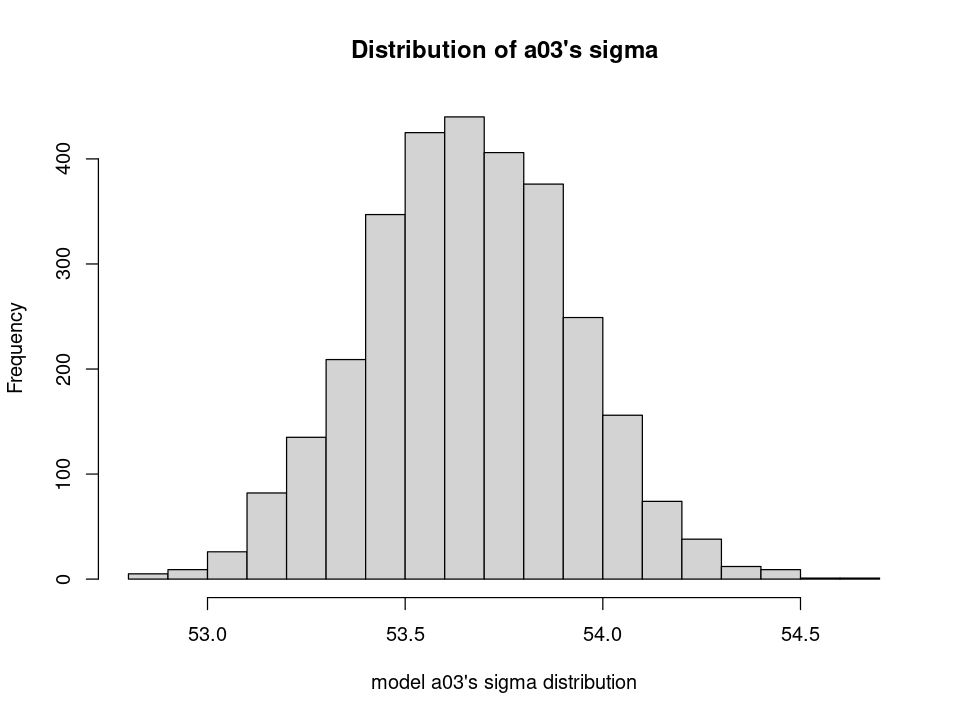

In [163]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.a03.sim, breaks=20, main="Distribution of a03's sigma",
     xlab="model a03's sigma distribution")


In [164]:
coef.a03.sim <- coef(a03.sim)
apply(coef.a03.sim, 2, quantile)


,(Intercept),I(long_transf^-1),I(long_transf^-1.5),latitude,I(latitude^2),I(latitude^3),I(latitude^4),I(households^0.55),I(households^1.1),I(median_house_value^0.48),I(median_house_value^0.24),I(HHdens_ln^1.35),I(HHdens_ln^2.7)
0%,-108935,387.39,-568.90,7463.7,-486.75,5.5003,-0.059986,-0.68950,0.0019836,0.22776,-11.606,-1.24768,0.072697
25%,-93142,431.66,-507.59,9329.9,-415.16,6.8903,-0.051048,-0.63905,0.0025905,0.26193,-10.670,-1.04153,0.081993
50%,-89234,442.82,-492.83,9737.1,-397.51,7.2015,-0.048831,-0.62556,0.0027285,0.26915,-10.405,-0.98877,0.084004
75%,-85585,455.07,-479.12,10165.7,-380.62,7.5233,-0.046708,-0.61304,0.0028787,0.27615,-10.131,-0.93499,0.085981
100%,-68522,505.73,-424.89,11905.1,-304.12,8.8312,-0.037251,-0.56204,0.0034367,0.30035,-8.796,-0.67930,0.093752


### Plot of imputed housing_median_age values

In [9]:
# I decided to go with "Approach 2" from Appendix A.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03b.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat); colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

In [11]:
# Construct dataframe for a before and after plot.

dat_wCap <- dat
dat_wCap[which(dat_wCap$housing_median_age > 52), c("housing_median_age")] <- 52


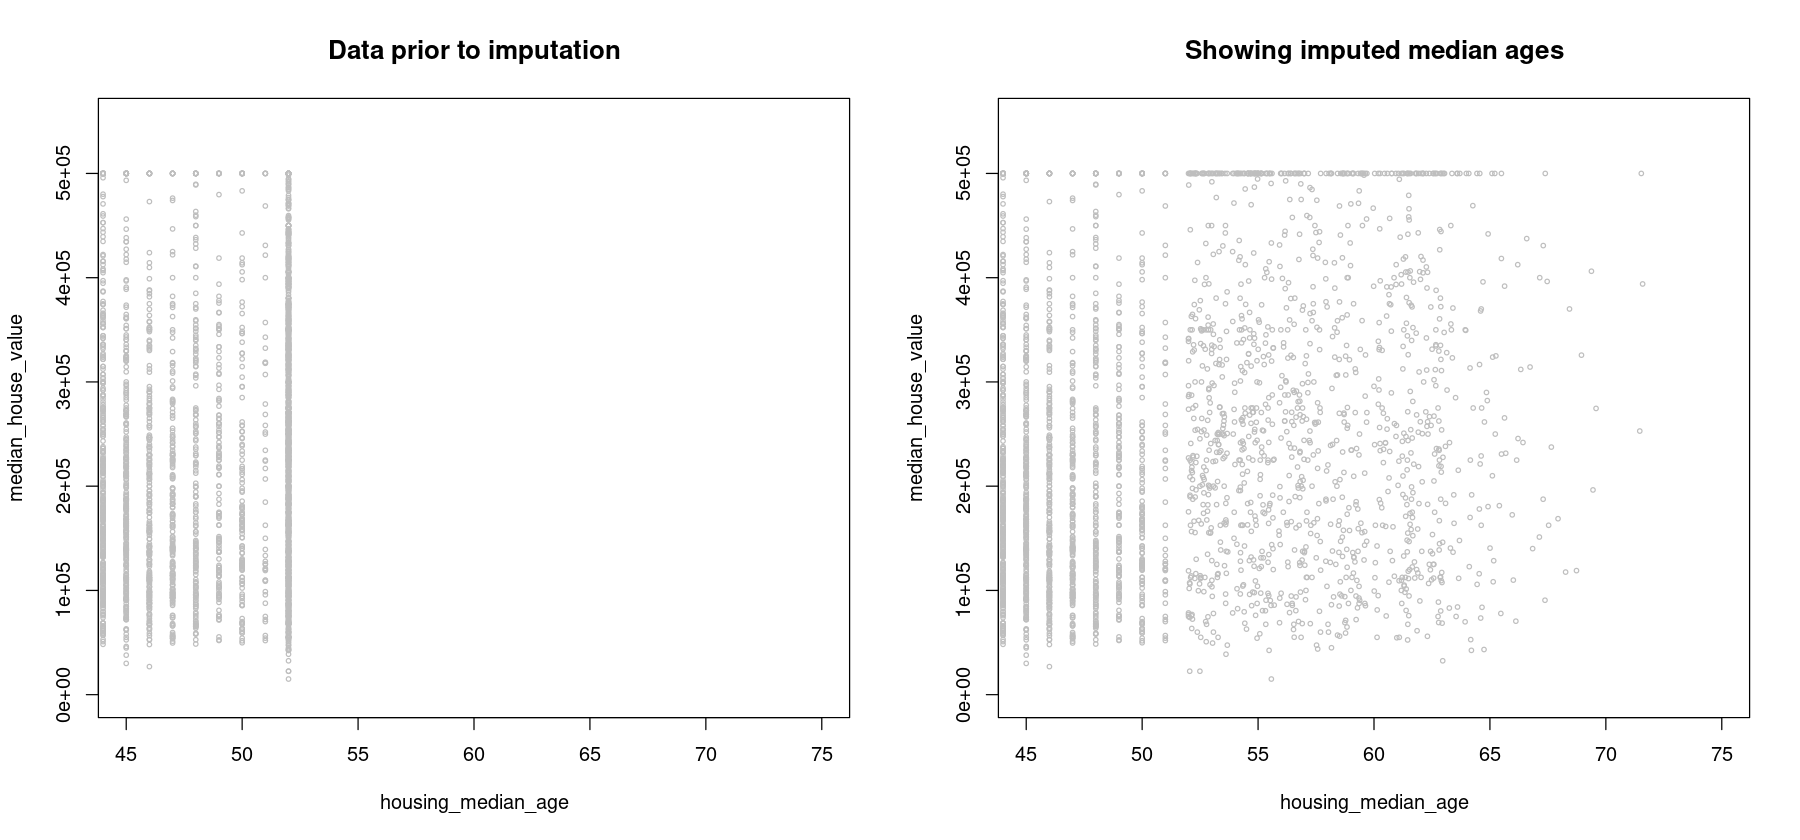

In [13]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# plot the "before" scatter
plot(dat_wCap$housing_median_age, dat_wCap$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Data prior to imputation", cex.main=1.3)


# plot the newly predicted values
plot(dat$housing_median_age, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Showing imputed median ages", cex.main= 1.3)


In [14]:
rm(dat_wCap)


## Impute for censored median_house_value

4.8\% of the records have a censored median_house_value.  The actual imputation is found in Appendix B.  In what follows, I simply show the model used in the imputation.  How did I arrive at this model?  We know from the above outputs what the most important predictors are for median_house_value and which of the predictors are collinear to a degree that they should not be found together in the same model.  The interaction terms are arrived at through backward elimination applied to a more complex model. 

In [28]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03b.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
summary(dat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

In [105]:
# This model has an adjusted R-sqrd of 0.73 and uses only 
# 6 predictors.

m01 <- lm(I(median_house_value^0.18) ~ 
          
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

## NOTE: dat contains the censored median_house_value data.
## dat contains imputed data for housing_median_age.

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.73

In [106]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00043388, Df = 1, p = 0.983

In [107]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.77)         -14.13           <2e-16
I(long_transf^-0.5)             1.99            0.046
I(long_transf^-1)              11.11           <2e-16
I(long_transf^-1.5)            11.55           <2e-16
latitude                        0.89            0.373
I(latitude^2)                  -0.40            0.692
I(latitude^3)                  33.30           <2e-16
I(latitude^4)                  33.28           <2e-16
pop_per_hh                     -1.32            0.186
I(pop_per_hh^2)               -13.36           <2e-16
I(housing_median_age^0.15)      0.46            0.645
HHdens_ln                      11.34           <2e-16
Tukey test                      0.07            0.944


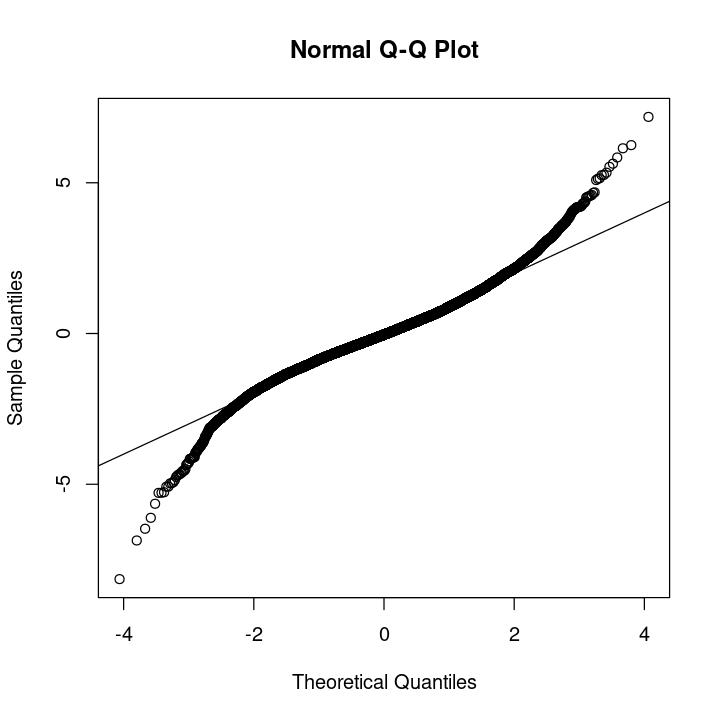

In [108]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [109]:
# Get a sense of the parameter distributions.

m01.sim <- sim(m01, n.sims=3000)


In [110]:
sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 0.469 0.469 0.465 0.47 0.467 ...


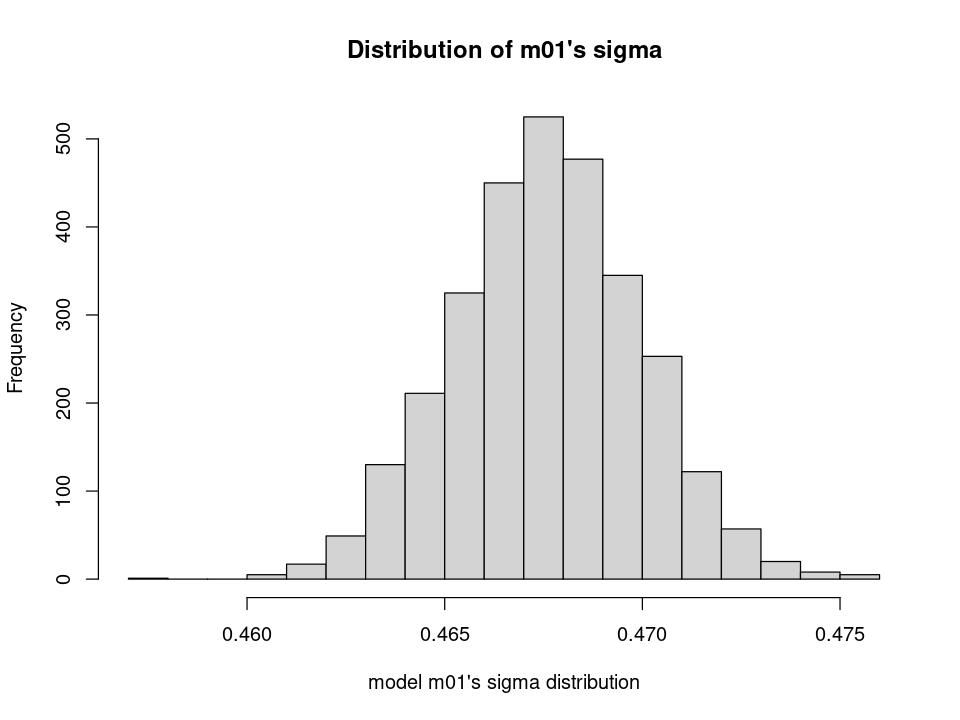

In [111]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


In [ ]:
# sigma.hat is small because of the power transformation
# on the response variable.


### Plot of imputed median_house_values

In [15]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03_adj01.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [16]:
# Construct dataframe for a before and after plot.

dat_wCap <- dat
dat_wCap[which(dat_wCap$median_house_value > 500000), c("median_house_value")] <- 500000


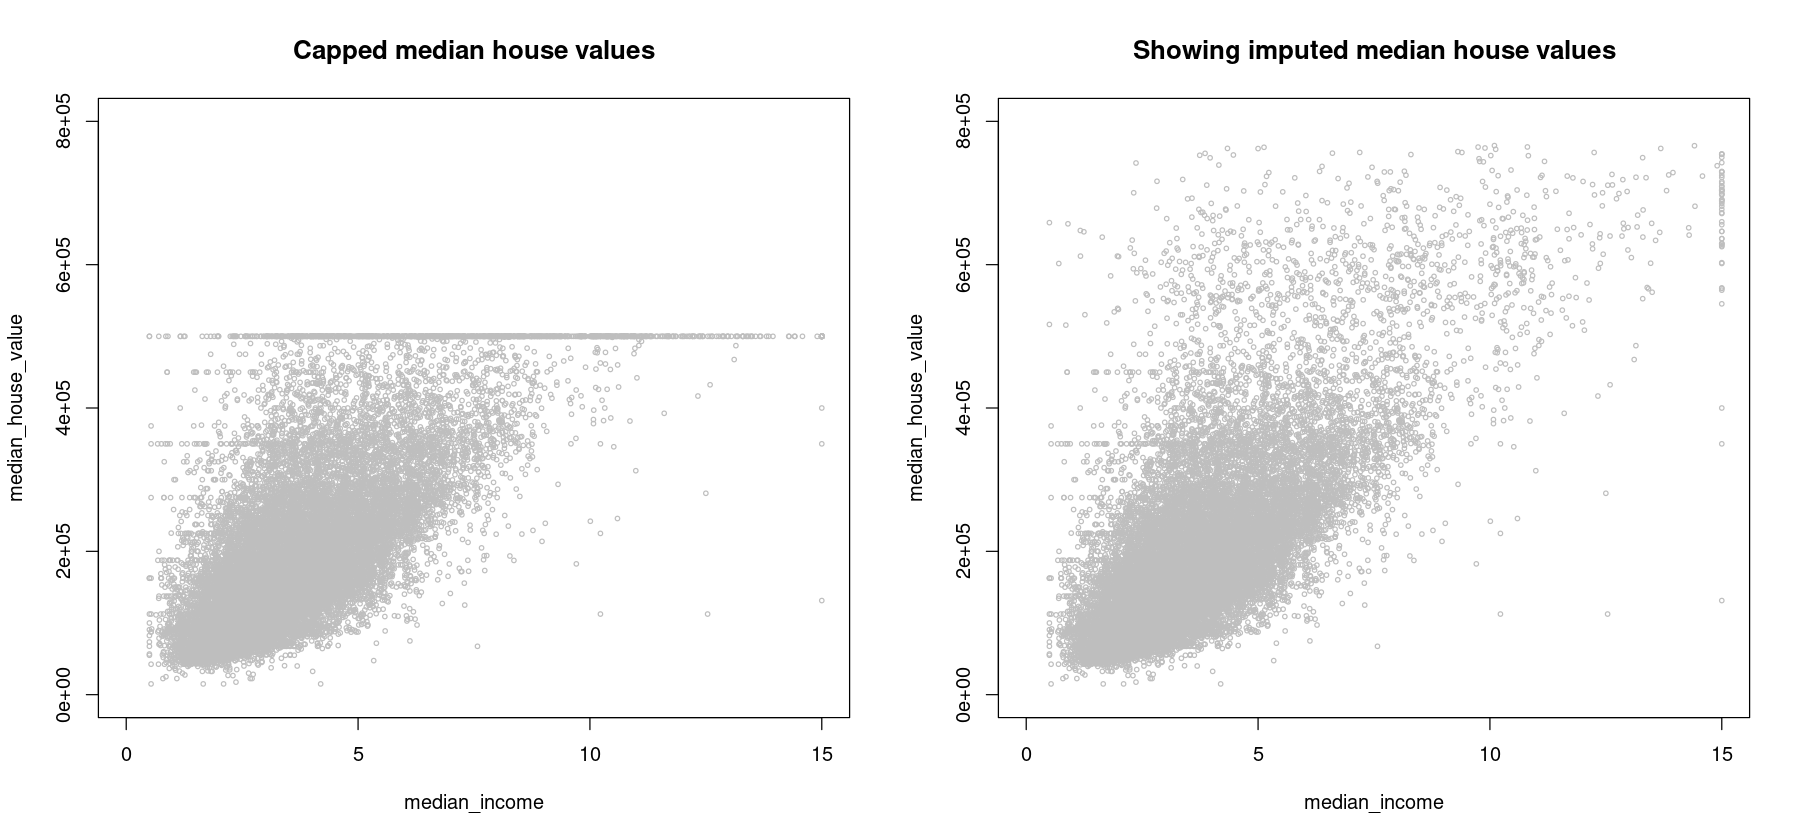

In [17]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# plot the "before" scatter
plot(dat_wCap$median_income, dat_wCap$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Capped median house values", cex.main=1.3)


# plot the newly predicted values
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Showing imputed median house values", cex.main=1.3)


In [18]:
rm(dat_wCap)


# Section 3: Create training and test sets using stratified sampling

Because median income is such a strong predictor of median house prices (its linear correlation with log(median_house_value) is over 65%), we want to use stratified sampling relative to this variable when creating the training and test sets.  This ensures that the training set is representative of the larger population (i.e., the data to which our models will be applied were we to put a model into production) with respect to the variable that likely matters most for the purpose of making good predictions. 

Following Geron's lead, we divide median income by 1.5 in order to reduce the number of income categories that we have to work with.  The max value for median_income is 15.

80 percent of the records will be used for the training set, the remainder for the test set.


In [19]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03_adj01.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)
colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

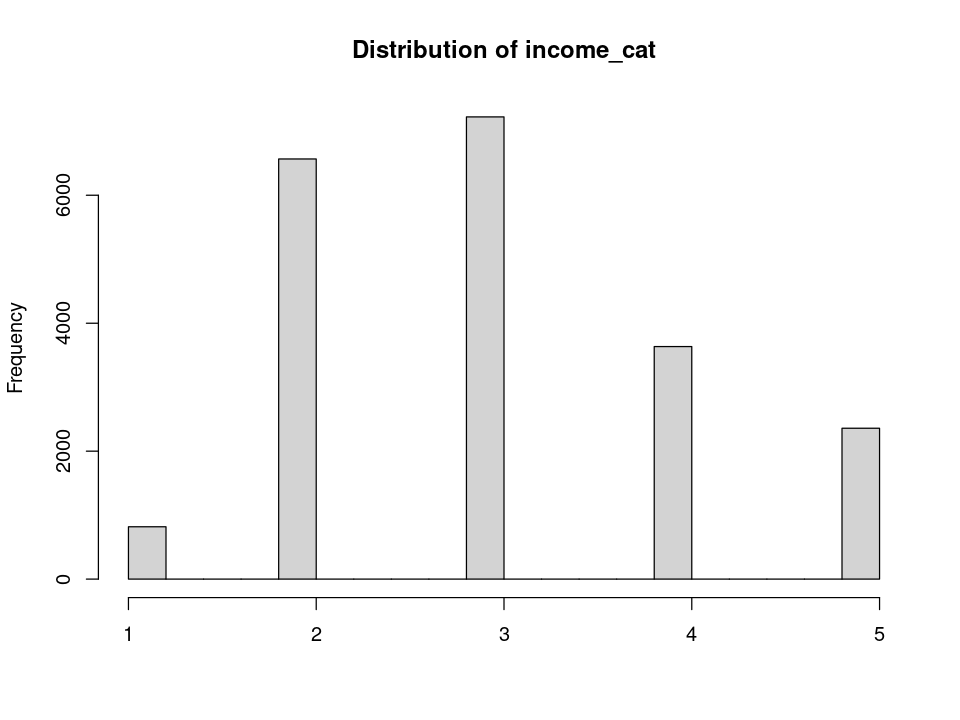

In [20]:
dat$income_cat <- ceiling(dat$median_income/ 1.5)

dat$income_cat <- ifelse(dat$income_cat > 5, 5, dat$income_cat)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(dat$income_cat, main="Distribution of income_cat", xlab="")


In [21]:
ans <- table(as.factor(dat$income_cat))
counts <- as.numeric(ans)
percents <- 100 * round(counts/nrow(dat), 4)
names(percents) <- names(ans); print(percents)

# Percent of records in each income category:


    1     2     3     4     5 
 3.97 31.87 35.07 17.64 11.44 


In [22]:
# Shuffle dat.

set.seed(4321)
smp <- sample(rownames(dat), nrow(dat), replace=FALSE)
dat <- dat[smp,]
smp02 <- sample(rownames(dat), nrow(dat), replace=FALSE)
dat <- dat[smp02,]
rm(smp, smp02)


In [23]:
# Construct training and test sets.

n.train <- floor(0.8 * nrow(dat))
n.test <- nrow(dat) - n.train
percents02 <- percents/100

total_rows <- 0
train_rows <- c()

for(lev in names(ans)) {
    
    percent <- as.numeric(percents02[lev])
    ifelse(as.numeric(lev) < 5, n <- round(percent*n.train),
           n <- n.train - total_rows)
    total_rows <- total_rows + n
    set.seed(9871)
    smp <- sample(rownames(dat[which(dat$income_cat== as.numeric(lev)),]),
                  n, replace=FALSE)
    train_rows <- c(train_rows, smp)
}

length(train_rows)== n.train


[1] TRUE

In [24]:
train <- dat[train_rows,]
test <- dat[which(!(rownames(dat) %in% rownames(train))),]
(nrow(test) + nrow(train)) == nrow(dat)

round(table(as.factor(train$income_cat))/nrow(train), 3)
round(table(as.factor(test$income_cat))/nrow(test), 3)


[1] TRUE


    1     2     3     4     5 
0.040 0.319 0.351 0.176 0.115 


    1     2     3     4     5 
0.040 0.319 0.351 0.177 0.114 

### Save to disk

In [25]:
# Shuffle train.
set.seed(4321)
smp <- sample(rownames(train), nrow(train), replace=FALSE)
train <- train[smp,]

# Shuffle test.
set.seed(4321)
smp <- sample(rownames(test), nrow(test), replace=FALSE)
test <- test[smp,]


write.csv(train, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_07DEC2021.csv",
          row.names=TRUE)

write.csv(test, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_07DEC2021.csv",
          row.names=TRUE)

dim(train)
# 16482   16


[1] 16482    16

# Section 4: Explore the data and consider more models

In [26]:
rm(dat, test)


In [3]:
train <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_07DEC2021.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5), "character"))
dim(train)
# 16,482    16

colnames(train)


[1] 16482    16

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"       
[16] "income_cat"

In [28]:
# Create a dataframe with the m02 predictors and their transformations.

smp <- sample(rownames(train), 7000, replace= FALSE)
df_plot <- train[smp, c("housing_median_age", "median_income", "HHdens_ln",
                        "latitude", "long_transf", "pop_per_hh")]
df_plot$housing_median_age <- df_plot$housing_median_age^0.15
df_plot$long_transf <- df_plot$long_transf^-1
df_plot$median_income <- df_plot$median_income^0.77


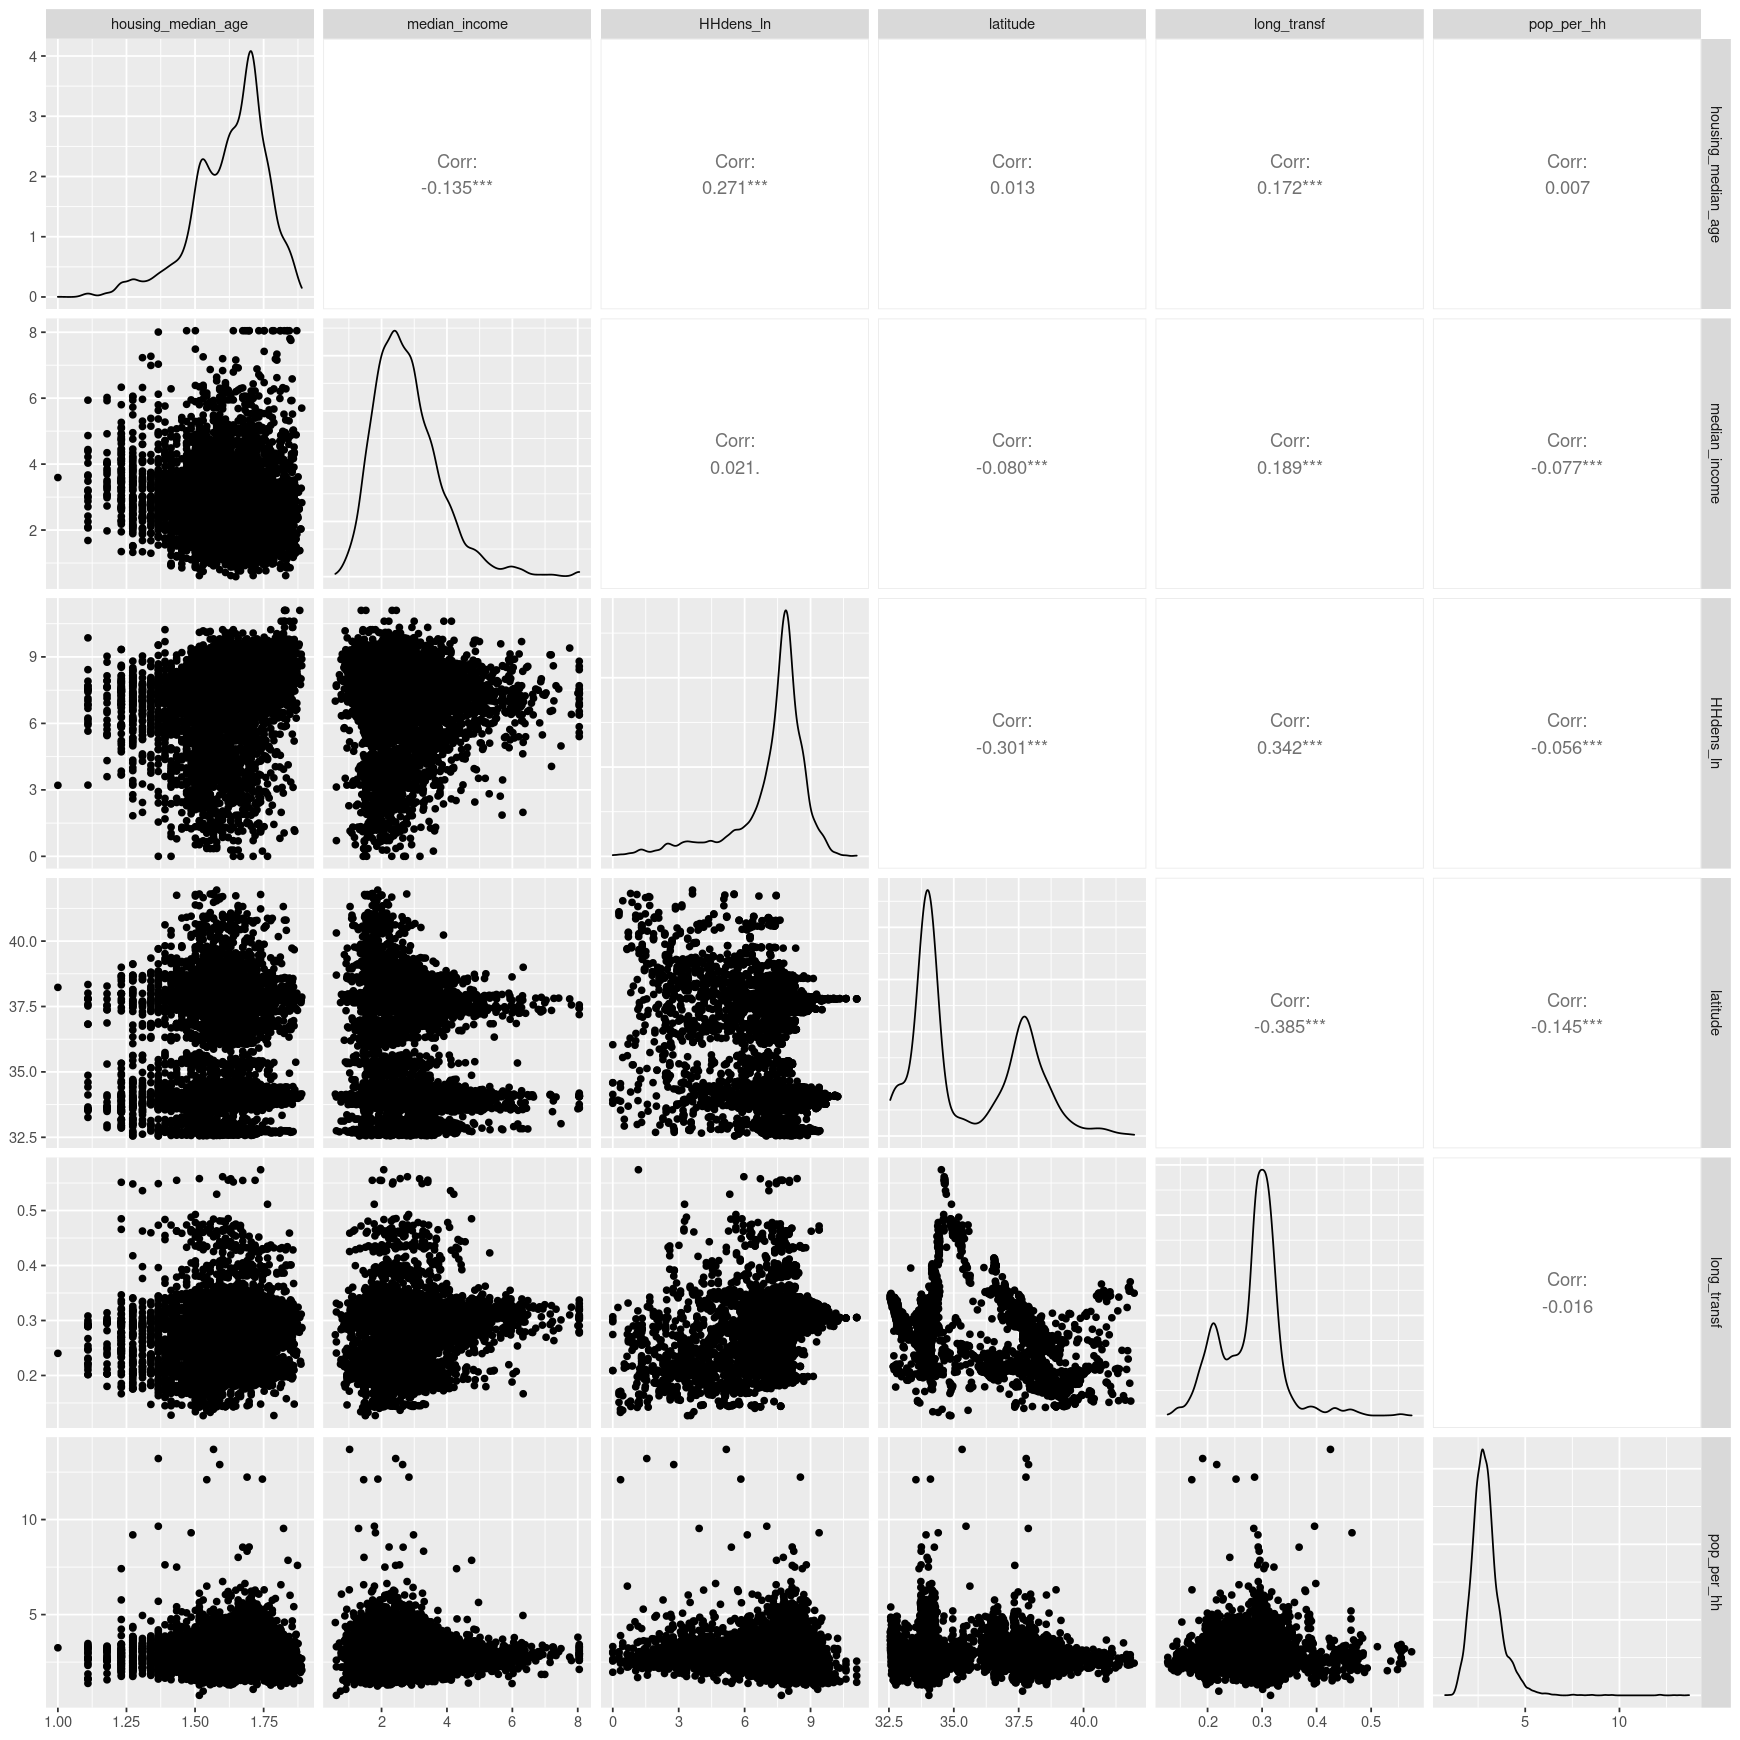

In [29]:
options(repr.plot.width= 14.5, repr.plot.height= 14.5)

p4 <- ggpairs(df_plot)
p4


In [ ]:
rm(df_plot)


In [66]:
# Look at a model that includes the ocean_proximity term.

# g02 is exactly like m02 except for the addition of 
# ocean_proximity and that it is constructed from 
# only the training set data.

g02 <- lm(I(median_house_value^0.09) ~ 
          
           I(median_income^0.81) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
          
           ocean_proximity +
          
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= train)  

g02.summary <- summary(g02)
g02.summary[[1]] <- ""; round(g02.summary$adj.r.squared, 3)


[1] 0.736

In [67]:
ncvTest(g02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.15385, Df = 1, p = 0.695

In [68]:
residualPlots(g02, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.81)          -9.21          < 2e-16
I(long_transf^-0.5)            -1.00             0.32
I(long_transf^-1)               6.71          2.0e-11
I(long_transf^-1.5)             7.10          1.3e-12
latitude                        0.97             0.33
I(latitude^2)                   0.09             0.93
I(latitude^3)                  28.92          < 2e-16
I(latitude^4)                  28.91          < 2e-16
pop_per_hh                     -1.49             0.14
I(pop_per_hh^2)               -12.58          < 2e-16
I(housing_median_age^0.15)     -0.50             0.62
HHdens_ln                      10.43          < 2e-16
Tukey test                     -0.01             0.99


In [ ]:
### COMMENT:

# Adding ocean_proximity to the model improves the R-sqrd by
# only two-tenths of one percent.  For our linear model, it
# may not be worth the trouble.  I will compare g02 with 
# the next model, g03, using rmse scores and cross-validation.


In [4]:
# Rename m02 to g03.  Model g03 is only on the training 
# set data.  Accordingly, it requires some further tuning.

response_var_power <- 0.103

g03 <- lm(I(median_house_value^response_var_power) ~ 
          
           I(median_income^0.825) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= train)  

g03.summary <- summary(g03)
g03.summary[[1]] <- ""; round(g03.summary$adj.r.squared, 3)


[1] 0.734

In [60]:
ncvTest(g03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0097256, Df = 1, p = 0.921

In [61]:
residualPlots(g03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.825)        -10.08           <2e-16
I(long_transf^-0.5)            -1.01             0.31
I(long_transf^-1)               9.82           <2e-16
I(long_transf^-1.5)            10.26           <2e-16
latitude                        0.93             0.35
I(latitude^2)                   0.00             1.00
I(latitude^3)                  30.13           <2e-16
I(latitude^4)                  30.11           <2e-16
pop_per_hh                      1.11             0.27
I(pop_per_hh^2)               -12.76           <2e-16
I(housing_median_age^0.15)     -0.60             0.55
HHdens_ln                      10.36           <2e-16
Tukey test                      0.10             0.92


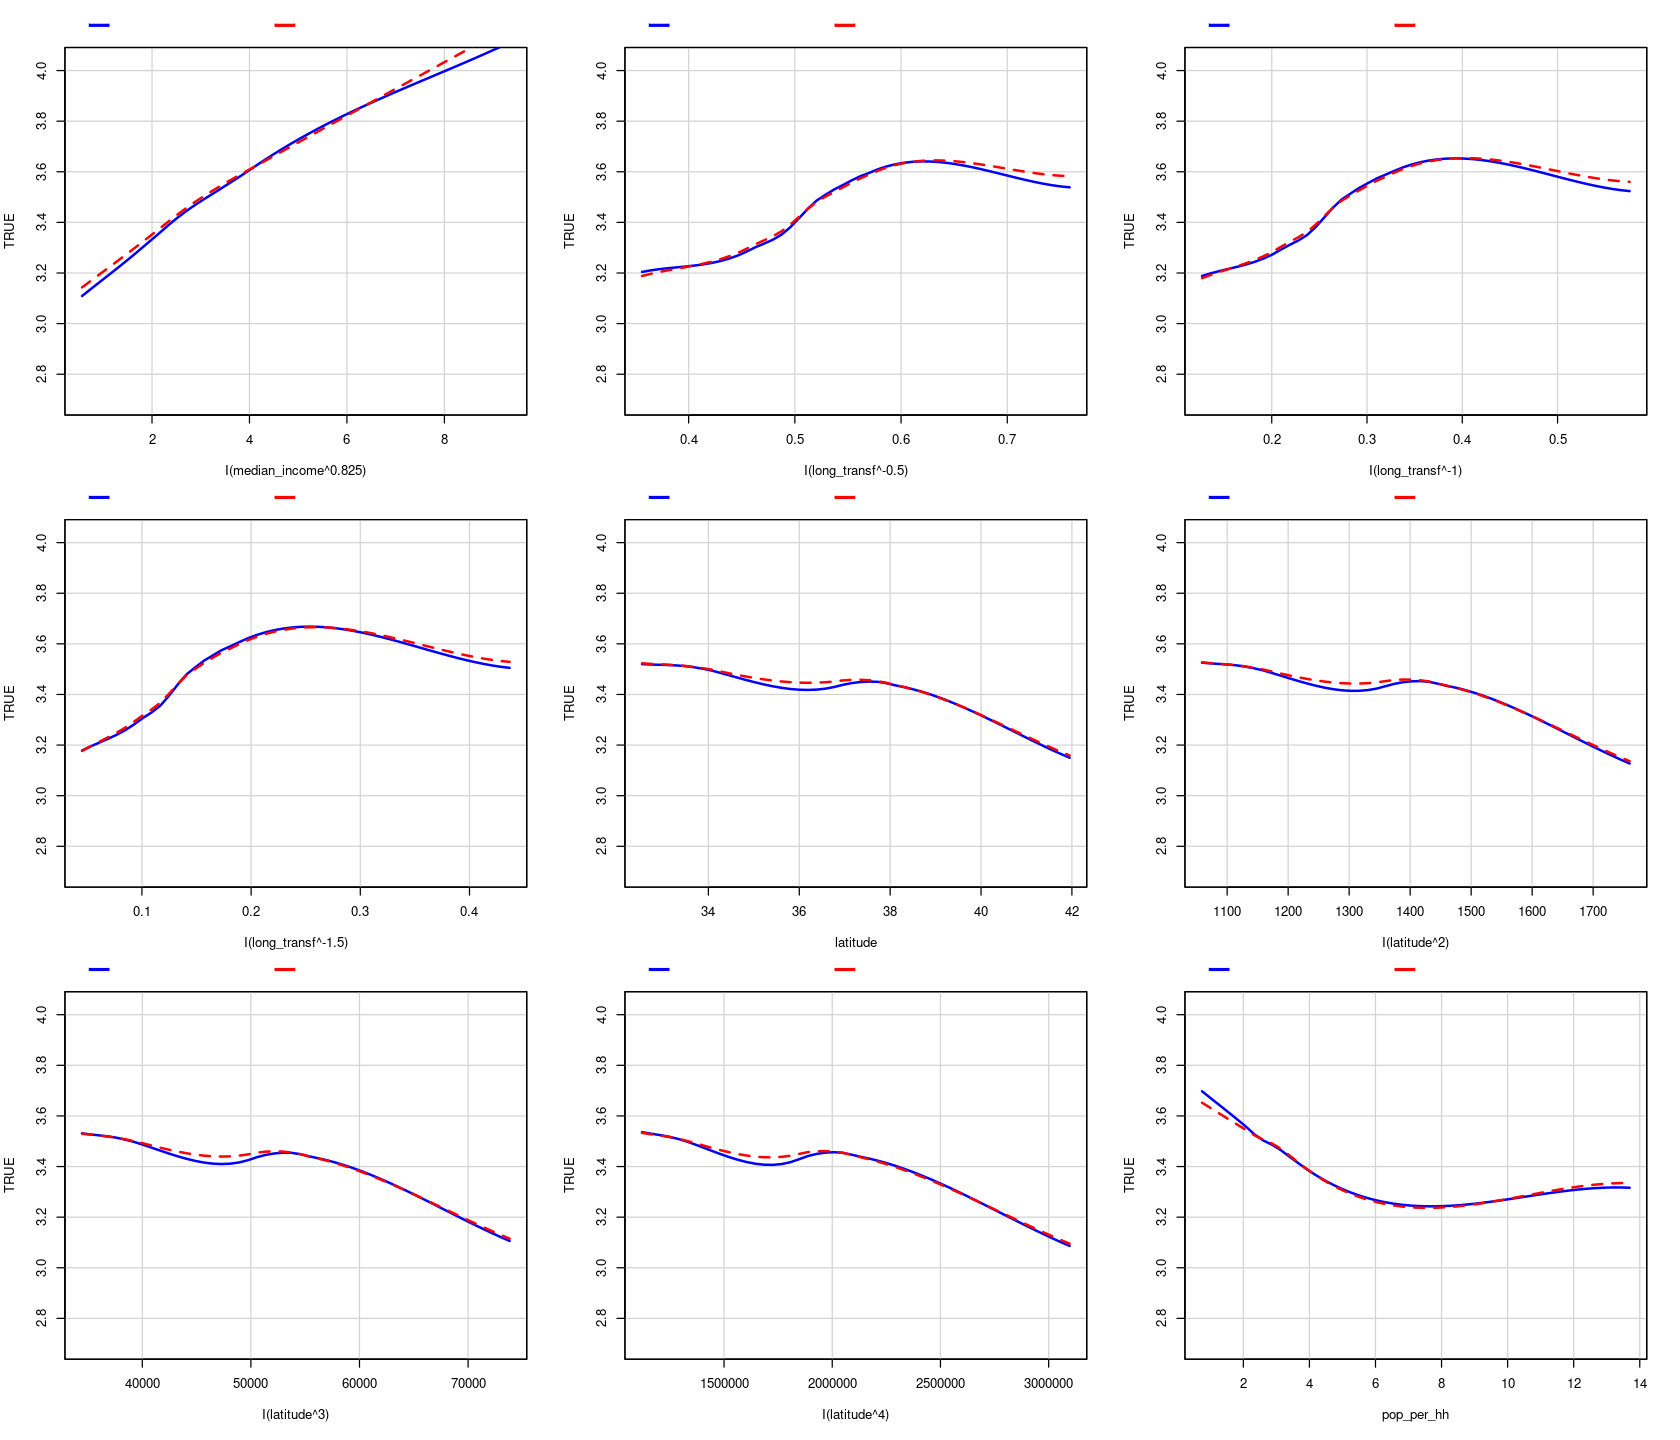

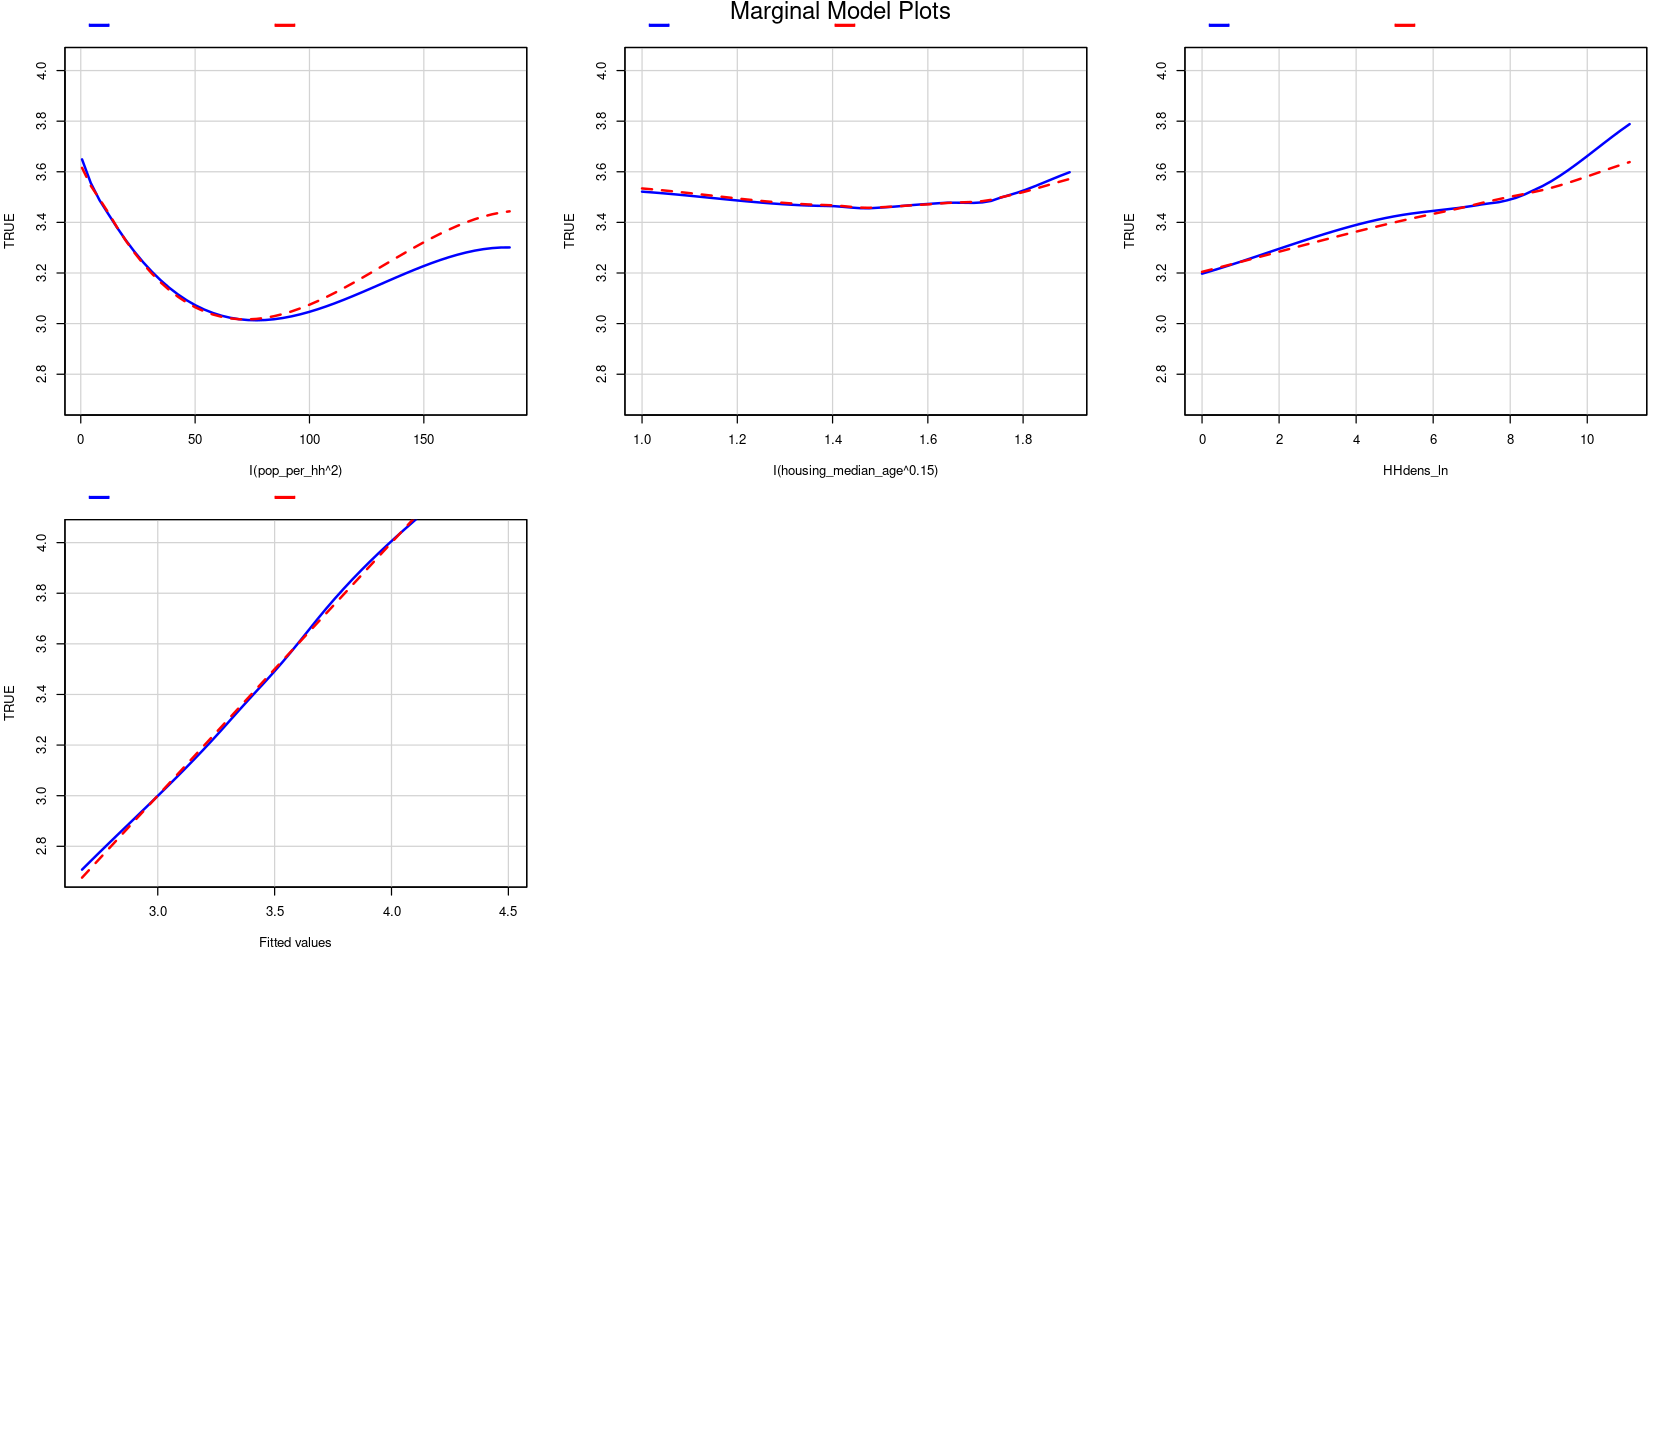

In [62]:
options(repr.plot.width= 14, repr.plot.height= 12)

# blue= data; red= model
suppressWarnings(mmps(g03, ~., pch=NA))


In [ ]:
### COMMENTS:

# g03 relies on only 6 predictors, all of which are numeric.
# The R-sqrd is 73.5%.  It has constant variance with
# respect to the fitted values, and it has linearity 
# with respect to the fitted values.  The marginal model
# plots look pretty good.


## Compute rmse on trainset for model g03

In [69]:
# rmse score on train set for g03.

response_var_power <- 0.103

predictions <- predict.lm(g03, newdata = train)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(train)) * sum((as.numeric(preds_transf) - 
                                          train$median_house_value)^2))))
# 76,047


[1] 76047


## Compute g03 rmse on testset

In [5]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_07DEC2021.csv",
                    header=TRUE, row.names=1,
                    colClasses= c("character", rep("numeric", 9), "character",
                                  rep("numeric", 5), "character"))
dim(testdat)
# 4121    16


[1] 4121   16

In [71]:
predictions <- predict.lm(g03, newdata = testdat)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(testdat)) * sum((as.numeric(preds_transf) - 
                                          testdat$median_house_value)^2))))
# 76,952


[1] 76952


In [72]:
# Get rmse score on the testset when median_house_value < 500K.

newtest <- testdat[which(testdat$median_house_value < 500000),]
dim(newtest)
# 3924     16

predictions <- predict.lm(g03, newdata = newtest)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(newtest)) * sum((as.numeric(preds_transf) - 
                                          newtest$median_house_value)^2))))
# 55,585


[1] 3924   16

[1] 55585


In [ ]:
### COMMENT:

# The average error increases by 21.4K once we include predictions
# for districts with a median_house_value >= 500K.  This large 
# delta illustrates how difficult it is to get accurate predictions
# for these districts.  Keep in mind that we have only a small 
# amount of data for this region of the response variable's range;
# only 4.5-5% of our trainset records are in this range.


In [73]:
# Get rmse score on the testset when median_house_value <= 150K.

newtest <- testdat[which(testdat$median_house_value <= 150000),]
dim(newtest)
# 1538     16

predictions <- predict.lm(g03, newdata = newtest)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(newtest)) * sum((as.numeric(preds_transf) - 
                                          newtest$median_house_value)^2))))
# 38,453

# The error is much larger than I would have thought.


[1] 1538   16

[1] 38453


# Section 5: geospatial plot

The following plot is useful for thinking about the data we are working with.

Only the training set data is plotted.



                                    * * * * * 

In [ ]:
# See https://r-spatial.org/r/2018/10/25/ggplot2-sf.html.
# Many of the following packages have important dependencies.
# Linux users might do best installing the packages in
# pure R (e.g., do not use RStudio or JupyterNotebooks).

require(sf)
theme_set(theme_bw())
require(rnaturalearth)
require(rnaturalearthdata)
require(sp)
require(rgeos)
require(maps)
require(ggspatial)


In [174]:
# Load state maps data.

states <- suppressMessages(st_as_sf(map("state", plot = FALSE, fill = TRUE)))
head(states)


,ID,geom
,<chr>,<MULTIPOLYGON [°]>
1,alabama,MULTIPOLYGON (((-87.462 30....
2,arizona,MULTIPOLYGON (((-114.64 35....
3,arkansas,MULTIPOLYGON (((-94.051 33....
4,california,MULTIPOLYGON (((-120.01 42....
5,colorado,MULTIPOLYGON (((-102.06 40....
6,connecticut,MULTIPOLYGON (((-73.499 42....


In [23]:
CA <- states[which(states$ID == "california"),]
dim(CA)


[1] 1 2

In [29]:
# Map county boundaries.

counties <- st_as_sf(map("county", plot = FALSE, fill = TRUE))
counties <- subset(counties, grepl("california", counties$ID))


In [161]:
# Prepare data for plotting.

geodat <- train[, c("longitude","latitude","population","median_house_value")]
geodat$median_house_value <- round(geodat$median_house_value/1000)

y <- cut(geodat$median_house_value, breaks=c(15, 90, 180, 360, 800), 
         include.lowest=TRUE, right=FALSE, ordered_result=TRUE)
table(y)

geodat$hhval_discrete <- y



geodat$population <- round(geodat$population)

zz <- cut(geodat$population, breaks=c(2, 800, 2400, 40000), 
          include.lowest=TRUE, right=FALSE, ordered_result=TRUE,
          labels=c("< 800", "800-2400"," >= 2400"))
table(zz)

geodat$pop_discrete <- zz


y
  [15,90)  [90,180) [180,360) [360,800] 
     2085      6115      6372      1910 

zz
   < 800 800-2400  >= 2400 
    4246    10290     1946 

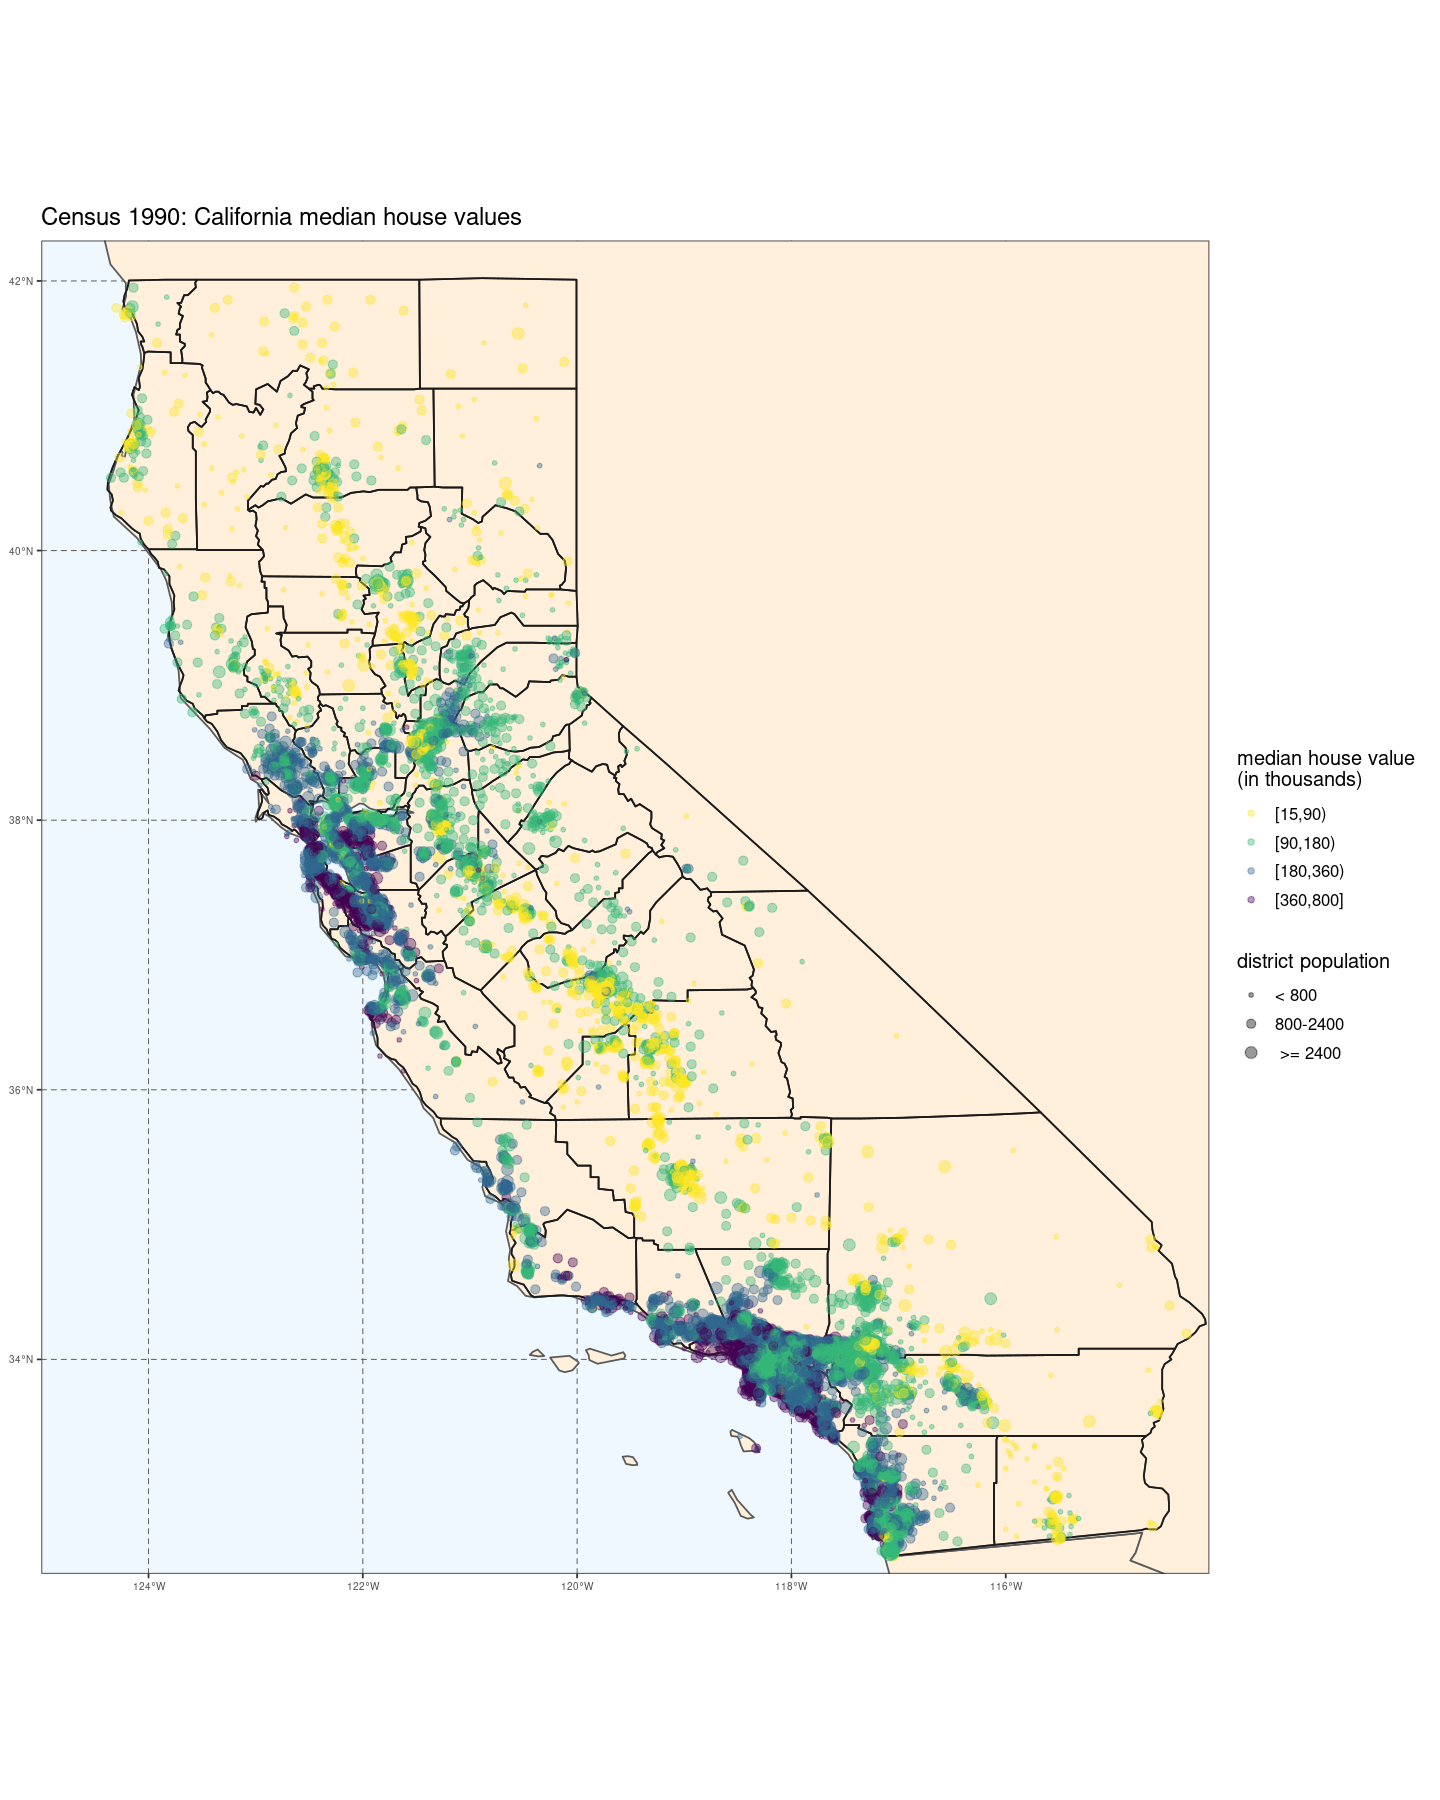

In [172]:
# The following plot is meant to be looked at in a pdf viewer.
# The saved pdf file is included in my CA_housing_analysis 
# repository.

options(repr.plot.width= 12, repr.plot.height= 15)

ggplot(data = world) +
    geom_sf(fill = "antiquewhite1") +
    geom_sf(data = CA, fill = NA) +
    geom_sf(data = counties, fill = NA, color = gray(.1)) +
    geom_point(data= geodat, mapping= aes(longitude, latitude,
                                          colour= hhval_discrete,
                                          size=pop_discrete), alpha=0.4) +
    suppressWarnings(scale_size_discrete(name="district population",
                                         range=c(1,3))) +
    scale_colour_viridis_d(alpha=0.7, direction=-1, name="median house value
(in thousands)") +
    coord_sf(xlim = c(-125.0, -114.1), ylim = c(32.41, 42.3), expand = FALSE) +
    ggtitle("Census 1990: California median house values") +
    theme(panel.grid.major = element_line(color = gray(0.4), linetype = "dashed", 
        size = 0.3), panel.background = element_rect(fill = "aliceblue")) +
    theme(axis.text= element_text(size = 6)) +
    theme(axis.title= element_blank()) +
    theme(title= element_text(size= 12)) +
    theme(legend.text= element_text(size=10)) +
    theme(legend.title=element_text(size=12))


In [173]:
ggsave("/home/greg/Documents/stat/github_repos/CA_housing/CA_housing_map_v01.pdf",
       device="pdf", scale=1, dpi=600, units="cm", width=18, height=36)


# Section 6: Comparative rmse score for model g03

We can get a much better score for comparing to the models of Part02 by averaging over many different samples of our testset data.


In [74]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_07DEC2021.csv",
                    header=TRUE, row.names=1,
                    colClasses= c("character", rep("numeric", 9), "character",
                                  rep("numeric", 5), "character"))
dim(testdat)
# 4121    16


[1] 4121   16

In [6]:
# Function for obtaining a set of scores on the testset data
# using model g03.

response_var_power <- 0.103
n_rcds <- 1000

get_testdatScores_g03 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    vout <- rep(NA, seedv_len)
    lst <- vector("list", length=2)
    names(lst) <- c("mean","sd")
    
    for(h in 1:seedv_len) {

        set.seed(seedv[h])
        # It is expected that dat is testdat, which has 4K rcds
        smp <- sample(rownames(dat), n_rcds, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict.lm(g03, newdata= df)
        preds_transf <- preds^(1/response_var_power)

        vout[h] <- round(sqrt((1/n_rcds) * sum((as.numeric(preds_transf) - 
                                          df$median_house_value)^2)))
    }
    
    lst[[1]] <- round(mean(vout))
    lst[[2]] <- round(sd(vout))
    return(lst)
}


In [7]:
# First shuffle testdat.

set.seed(6514)
smp01 <- sample(rownames(testdat), nrow(testdat), replace=FALSE)
testdat <- testdat[smp01,]
smp02 <- sample(rownames(testdat), nrow(testdat), replace=FALSE)
testdat <- testdat[smp02,]


In [8]:
# Get comparative rmse score for model g03.

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
g03_info <- get_testdatScores_g03(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.12 mins

# This is the average rmse for model g03:
print(g03_info[[1]])
# 76,773

# This is the average stddev for the g03 predictions:
print(g03_info[[2]])
# 4,265


Time difference of 1.54 secs

[1] 76773
[1] 4265


In [9]:
# Get a comparative rmse score for model g03 when 
# testdat$median_house_value < 500K.

newdat <- testdat[which(testdat$median_house_value < 500000),]

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
g03_info02 <- get_testdatScores_g03(seed_vector, newdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.12 mins

# Average rmse when predicting for districts whose real value is < 500K:
print(g03_info02[[1]])
# 55,605

# Corresponding rmse stddev:
print(g03_info02[[2]])
# 3,235


Time difference of 1.56 secs

[1] 55605
[1] 3235


# Final Comments on Part01

Our current best linear model is g03.  Its rmse score on the testset data is **76.8K** and its rmse score on the testset data below 500K is **55.6K**.  While we will be able to find much better predictive models in Part02, none will be as transparent as g03.  

The main predictors for median house value in model g03 are income, location, and urbanacity.  Less important predictors are a district's housing_median_age and a district's population per household.  

We can make use of g03's training set residuals to improve our predictions on the testset data, but there will be a price in terms of computation time.  One method is to identify nearest neighbors in the trainset data, where nearness is measured not simply in terms of distance but also in terms of the relative importance of each predictor in the model.  We can then compute an offset for the prediction of each record of the testset data by taking a weighted average of the residuals of the record's nearest neighbors in the trainset data.  I have seen about a 3% reduction in the rmse score for predictions < 500K using this method.

A closer look at g03's residuals will likely provide valuable insights for constructing better linear models.  I leave that project for another time.

